# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0') # 200 steps/rewards total
env = gym.make('CartPole-v1') # 500 steps/rewards total

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 2000                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [10]:
# Now train with experiences
saver = tf.train.Saver()
total_rewards_list = []
average_rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    total_rewards_deque = deque(maxlen=100)
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
            
        total_rewards_deque.append(total_reward)
        total_rewards_list.append((ep, total_reward))
        average_rewards_list.append((ep, np.mean(total_rewards_deque)))
        print('Episode: {}'.format(ep),
              'Aeverage Total reward: {:.2f}'.format(np.mean(total_rewards_deque)),
              'Total reward: {:.2f}'.format(total_reward),
              'Training loss: {:.4f}'.format(loss),
              'Explore P: {:.4f}'.format(explore_p))
        #print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(ep, np.mean(total_rewards_deque)))  
        if np.mean(total_rewards_deque) >= 500:
            break
        
    saver.save(sess, "checkpoints/model.ckpt")

Episode: 1 Aeverage Total reward: 1.00 Total reward: 1.00 Training loss: 1.0729 Explore P: 0.9999
Episode: 2 Aeverage Total reward: 6.00 Total reward: 11.00 Training loss: 1.0530 Explore P: 0.9988
Episode: 3 Aeverage Total reward: 15.00 Total reward: 33.00 Training loss: 1.0950 Explore P: 0.9956
Episode: 4 Aeverage Total reward: 15.75 Total reward: 18.00 Training loss: 1.0207 Explore P: 0.9938
Episode: 5 Aeverage Total reward: 16.40 Total reward: 19.00 Training loss: 1.0942 Explore P: 0.9919
Episode: 6 Aeverage Total reward: 15.33 Total reward: 10.00 Training loss: 1.0830 Explore P: 0.9909
Episode: 7 Aeverage Total reward: 15.14 Total reward: 14.00 Training loss: 1.1908 Explore P: 0.9896
Episode: 8 Aeverage Total reward: 17.62 Total reward: 35.00 Training loss: 1.2065 Explore P: 0.9861
Episode: 9 Aeverage Total reward: 17.00 Total reward: 12.00 Training loss: 1.3135 Explore P: 0.9850
Episode: 10 Aeverage Total reward: 16.60 Total reward: 13.00 Training loss: 1.1794 Explore P: 0.9837
Ep

Episode: 84 Aeverage Total reward: 17.81 Total reward: 20.00 Training loss: 67.4868 Explore P: 0.8624
Episode: 85 Aeverage Total reward: 17.89 Total reward: 25.00 Training loss: 8.9945 Explore P: 0.8603
Episode: 86 Aeverage Total reward: 17.91 Total reward: 19.00 Training loss: 8.4745 Explore P: 0.8587
Episode: 87 Aeverage Total reward: 17.97 Total reward: 23.00 Training loss: 115.7914 Explore P: 0.8567
Episode: 88 Aeverage Total reward: 17.91 Total reward: 13.00 Training loss: 75.6787 Explore P: 0.8556
Episode: 89 Aeverage Total reward: 17.83 Total reward: 11.00 Training loss: 8.8056 Explore P: 0.8547
Episode: 90 Aeverage Total reward: 17.79 Total reward: 14.00 Training loss: 7.5913 Explore P: 0.8535
Episode: 91 Aeverage Total reward: 17.71 Total reward: 11.00 Training loss: 7.4199 Explore P: 0.8526
Episode: 92 Aeverage Total reward: 17.72 Total reward: 18.00 Training loss: 10.2242 Explore P: 0.8511
Episode: 93 Aeverage Total reward: 17.71 Total reward: 17.00 Training loss: 31.3010 Ex

Episode: 164 Aeverage Total reward: 17.34 Total reward: 14.00 Training loss: 4.3663 Explore P: 0.7489
Episode: 165 Aeverage Total reward: 17.31 Total reward: 12.00 Training loss: 104.0838 Explore P: 0.7480
Episode: 166 Aeverage Total reward: 17.33 Total reward: 14.00 Training loss: 132.3269 Explore P: 0.7470
Episode: 167 Aeverage Total reward: 17.29 Total reward: 11.00 Training loss: 4.1766 Explore P: 0.7462
Episode: 168 Aeverage Total reward: 17.31 Total reward: 15.00 Training loss: 3.4277 Explore P: 0.7451
Episode: 169 Aeverage Total reward: 17.16 Total reward: 10.00 Training loss: 47.4102 Explore P: 0.7444
Episode: 170 Aeverage Total reward: 17.16 Total reward: 13.00 Training loss: 136.6608 Explore P: 0.7434
Episode: 171 Aeverage Total reward: 17.22 Total reward: 18.00 Training loss: 64.9060 Explore P: 0.7421
Episode: 172 Aeverage Total reward: 17.35 Total reward: 23.00 Training loss: 44.9163 Explore P: 0.7404
Episode: 173 Aeverage Total reward: 17.45 Total reward: 24.00 Training lo

Episode: 246 Aeverage Total reward: 15.58 Total reward: 11.00 Training loss: 67.3810 Explore P: 0.6639
Episode: 247 Aeverage Total reward: 15.62 Total reward: 14.00 Training loss: 3.6985 Explore P: 0.6630
Episode: 248 Aeverage Total reward: 15.71 Total reward: 24.00 Training loss: 105.8946 Explore P: 0.6614
Episode: 249 Aeverage Total reward: 15.71 Total reward: 10.00 Training loss: 73.9656 Explore P: 0.6607
Episode: 250 Aeverage Total reward: 15.92 Total reward: 36.00 Training loss: 34.0390 Explore P: 0.6584
Episode: 251 Aeverage Total reward: 15.68 Total reward: 11.00 Training loss: 14.7853 Explore P: 0.6577
Episode: 252 Aeverage Total reward: 15.68 Total reward: 25.00 Training loss: 2.9284 Explore P: 0.6561
Episode: 253 Aeverage Total reward: 15.69 Total reward: 11.00 Training loss: 1.4776 Explore P: 0.6554
Episode: 254 Aeverage Total reward: 15.72 Total reward: 14.00 Training loss: 33.0686 Explore P: 0.6545
Episode: 255 Aeverage Total reward: 15.61 Total reward: 15.00 Training loss

Episode: 327 Aeverage Total reward: 15.51 Total reward: 14.00 Training loss: 2.0776 Explore P: 0.5871
Episode: 328 Aeverage Total reward: 15.42 Total reward: 12.00 Training loss: 27.9930 Explore P: 0.5864
Episode: 329 Aeverage Total reward: 15.52 Total reward: 19.00 Training loss: 50.0443 Explore P: 0.5853
Episode: 330 Aeverage Total reward: 15.47 Total reward: 9.00 Training loss: 9.9508 Explore P: 0.5848
Episode: 331 Aeverage Total reward: 15.57 Total reward: 26.00 Training loss: 1.4636 Explore P: 0.5833
Episode: 332 Aeverage Total reward: 15.55 Total reward: 10.00 Training loss: 22.1571 Explore P: 0.5827
Episode: 333 Aeverage Total reward: 15.45 Total reward: 9.00 Training loss: 37.0130 Explore P: 0.5822
Episode: 334 Aeverage Total reward: 15.39 Total reward: 10.00 Training loss: 20.1771 Explore P: 0.5816
Episode: 335 Aeverage Total reward: 15.39 Total reward: 10.00 Training loss: 1.0926 Explore P: 0.5811
Episode: 336 Aeverage Total reward: 15.28 Total reward: 10.00 Training loss: 1.

Episode: 409 Aeverage Total reward: 19.51 Total reward: 24.00 Training loss: 1.8216 Explore P: 0.4966
Episode: 410 Aeverage Total reward: 19.71 Total reward: 31.00 Training loss: 12.4799 Explore P: 0.4951
Episode: 411 Aeverage Total reward: 19.83 Total reward: 21.00 Training loss: 42.9314 Explore P: 0.4941
Episode: 412 Aeverage Total reward: 19.92 Total reward: 22.00 Training loss: 24.6076 Explore P: 0.4930
Episode: 413 Aeverage Total reward: 20.01 Total reward: 23.00 Training loss: 1.5283 Explore P: 0.4919
Episode: 414 Aeverage Total reward: 20.08 Total reward: 15.00 Training loss: 11.7465 Explore P: 0.4912
Episode: 415 Aeverage Total reward: 20.11 Total reward: 18.00 Training loss: 10.4529 Explore P: 0.4903
Episode: 416 Aeverage Total reward: 20.15 Total reward: 26.00 Training loss: 11.7773 Explore P: 0.4891
Episode: 417 Aeverage Total reward: 20.22 Total reward: 21.00 Training loss: 29.2366 Explore P: 0.4881
Episode: 418 Aeverage Total reward: 20.36 Total reward: 24.00 Training loss

Episode: 489 Aeverage Total reward: 33.27 Total reward: 108.00 Training loss: 27.0771 Explore P: 0.3723
Episode: 490 Aeverage Total reward: 33.52 Total reward: 45.00 Training loss: 26.2505 Explore P: 0.3707
Episode: 491 Aeverage Total reward: 33.72 Total reward: 46.00 Training loss: 47.5148 Explore P: 0.3691
Episode: 492 Aeverage Total reward: 33.92 Total reward: 38.00 Training loss: 2.6654 Explore P: 0.3677
Episode: 493 Aeverage Total reward: 34.38 Total reward: 63.00 Training loss: 2.2093 Explore P: 0.3655
Episode: 494 Aeverage Total reward: 35.20 Total reward: 101.00 Training loss: 1.6558 Explore P: 0.3619
Episode: 495 Aeverage Total reward: 35.41 Total reward: 44.00 Training loss: 1.7298 Explore P: 0.3603
Episode: 496 Aeverage Total reward: 35.67 Total reward: 51.00 Training loss: 3.2115 Explore P: 0.3586
Episode: 497 Aeverage Total reward: 35.98 Total reward: 50.00 Training loss: 15.1541 Explore P: 0.3568
Episode: 498 Aeverage Total reward: 36.41 Total reward: 55.00 Training loss:

Episode: 569 Aeverage Total reward: 70.52 Total reward: 51.00 Training loss: 2.5581 Explore P: 0.2104
Episode: 570 Aeverage Total reward: 70.39 Total reward: 40.00 Training loss: 1.4876 Explore P: 0.2096
Episode: 571 Aeverage Total reward: 70.96 Total reward: 82.00 Training loss: 2.1036 Explore P: 0.2079
Episode: 572 Aeverage Total reward: 71.85 Total reward: 116.00 Training loss: 58.3072 Explore P: 0.2057
Episode: 573 Aeverage Total reward: 71.55 Total reward: 54.00 Training loss: 99.9551 Explore P: 0.2046
Episode: 574 Aeverage Total reward: 71.76 Total reward: 62.00 Training loss: 3.4910 Explore P: 0.2034
Episode: 575 Aeverage Total reward: 71.29 Total reward: 52.00 Training loss: 2.1099 Explore P: 0.2024
Episode: 576 Aeverage Total reward: 71.54 Total reward: 71.00 Training loss: 2.3580 Explore P: 0.2010
Episode: 577 Aeverage Total reward: 71.70 Total reward: 53.00 Training loss: 2.7600 Explore P: 0.2000
Episode: 578 Aeverage Total reward: 71.96 Total reward: 55.00 Training loss: 1.

Episode: 649 Aeverage Total reward: 138.51 Total reward: 499.00 Training loss: 104.5387 Explore P: 0.0704
Episode: 650 Aeverage Total reward: 141.56 Total reward: 499.00 Training loss: 0.9158 Explore P: 0.0675
Episode: 651 Aeverage Total reward: 143.66 Total reward: 303.00 Training loss: 0.7736 Explore P: 0.0658
Episode: 652 Aeverage Total reward: 148.06 Total reward: 499.00 Training loss: 0.3281 Explore P: 0.0630
Episode: 653 Aeverage Total reward: 151.03 Total reward: 499.00 Training loss: 0.5396 Explore P: 0.0605
Episode: 654 Aeverage Total reward: 155.47 Total reward: 499.00 Training loss: 0.3547 Explore P: 0.0580
Episode: 655 Aeverage Total reward: 158.91 Total reward: 405.00 Training loss: 0.5365 Explore P: 0.0561
Episode: 656 Aeverage Total reward: 163.31 Total reward: 499.00 Training loss: 0.3795 Explore P: 0.0539
Episode: 657 Aeverage Total reward: 166.46 Total reward: 499.00 Training loss: 0.3816 Explore P: 0.0517
Episode: 658 Aeverage Total reward: 170.71 Total reward: 499.0

Episode: 728 Aeverage Total reward: 321.74 Total reward: 97.00 Training loss: 0.1610 Explore P: 0.0143
Episode: 729 Aeverage Total reward: 321.67 Total reward: 82.00 Training loss: 0.1575 Explore P: 0.0143
Episode: 730 Aeverage Total reward: 321.98 Total reward: 188.00 Training loss: 0.3369 Explore P: 0.0142
Episode: 731 Aeverage Total reward: 322.04 Total reward: 114.00 Training loss: 0.1987 Explore P: 0.0142
Episode: 732 Aeverage Total reward: 321.63 Total reward: 100.00 Training loss: 0.2760 Explore P: 0.0141
Episode: 733 Aeverage Total reward: 324.54 Total reward: 499.00 Training loss: 0.2511 Explore P: 0.0139
Episode: 734 Aeverage Total reward: 323.43 Total reward: 100.00 Training loss: 0.3589 Explore P: 0.0139
Episode: 735 Aeverage Total reward: 323.46 Total reward: 94.00 Training loss: 0.4510 Explore P: 0.0139
Episode: 736 Aeverage Total reward: 322.33 Total reward: 88.00 Training loss: 0.4417 Explore P: 0.0138
Episode: 737 Aeverage Total reward: 318.11 Total reward: 77.00 Train

Episode: 808 Aeverage Total reward: 136.07 Total reward: 117.00 Training loss: 0.5784 Explore P: 0.0114
Episode: 809 Aeverage Total reward: 136.28 Total reward: 145.00 Training loss: 0.3771 Explore P: 0.0114
Episode: 810 Aeverage Total reward: 137.11 Total reward: 210.00 Training loss: 0.4460 Explore P: 0.0114
Episode: 811 Aeverage Total reward: 141.12 Total reward: 499.00 Training loss: 393.0378 Explore P: 0.0113
Episode: 812 Aeverage Total reward: 144.70 Total reward: 499.00 Training loss: 307.3890 Explore P: 0.0112
Episode: 813 Aeverage Total reward: 148.68 Total reward: 499.00 Training loss: 0.2813 Explore P: 0.0112
Episode: 814 Aeverage Total reward: 148.87 Total reward: 117.00 Training loss: 0.4588 Explore P: 0.0111
Episode: 815 Aeverage Total reward: 148.62 Total reward: 88.00 Training loss: 271.1732 Explore P: 0.0111
Episode: 816 Aeverage Total reward: 149.58 Total reward: 196.00 Training loss: 252.1263 Explore P: 0.0111
Episode: 817 Aeverage Total reward: 149.88 Total reward: 

Episode: 888 Aeverage Total reward: 97.73 Total reward: 26.00 Training loss: 1.5182 Explore P: 0.0106
Episode: 889 Aeverage Total reward: 97.88 Total reward: 32.00 Training loss: 3.5506 Explore P: 0.0106
Episode: 890 Aeverage Total reward: 98.00 Total reward: 27.00 Training loss: 1.4758 Explore P: 0.0106
Episode: 891 Aeverage Total reward: 98.16 Total reward: 29.00 Training loss: 1.7631 Explore P: 0.0106
Episode: 892 Aeverage Total reward: 98.35 Total reward: 35.00 Training loss: 159.8943 Explore P: 0.0106
Episode: 893 Aeverage Total reward: 99.35 Total reward: 114.00 Training loss: 2.7945 Explore P: 0.0105
Episode: 894 Aeverage Total reward: 100.59 Total reward: 143.00 Training loss: 1.7172 Explore P: 0.0105
Episode: 895 Aeverage Total reward: 101.70 Total reward: 138.00 Training loss: 2.4312 Explore P: 0.0105
Episode: 896 Aeverage Total reward: 103.59 Total reward: 205.00 Training loss: 1.5742 Explore P: 0.0105
Episode: 897 Aeverage Total reward: 108.37 Total reward: 499.00 Training 

Episode: 969 Aeverage Total reward: 128.89 Total reward: 165.00 Training loss: 961.6550 Explore P: 0.0102
Episode: 970 Aeverage Total reward: 128.85 Total reward: 19.00 Training loss: 5.0708 Explore P: 0.0102
Episode: 971 Aeverage Total reward: 130.68 Total reward: 208.00 Training loss: 5.4796 Explore P: 0.0102
Episode: 972 Aeverage Total reward: 130.67 Total reward: 18.00 Training loss: 3.6970 Explore P: 0.0102
Episode: 973 Aeverage Total reward: 130.54 Total reward: 15.00 Training loss: 5.1150 Explore P: 0.0102
Episode: 974 Aeverage Total reward: 129.64 Total reward: 15.00 Training loss: 3.0070 Explore P: 0.0102
Episode: 975 Aeverage Total reward: 129.54 Total reward: 18.00 Training loss: 5.3047 Explore P: 0.0102
Episode: 976 Aeverage Total reward: 129.44 Total reward: 18.00 Training loss: 4.8498 Explore P: 0.0102
Episode: 977 Aeverage Total reward: 129.36 Total reward: 17.00 Training loss: 4.6511 Explore P: 0.0102
Episode: 978 Aeverage Total reward: 131.02 Total reward: 189.00 Train

Episode: 1048 Aeverage Total reward: 348.08 Total reward: 499.00 Training loss: 0.1669 Explore P: 0.0100
Episode: 1049 Aeverage Total reward: 348.57 Total reward: 499.00 Training loss: 0.0652 Explore P: 0.0100
Episode: 1050 Aeverage Total reward: 348.70 Total reward: 496.00 Training loss: 0.2357 Explore P: 0.0100
Episode: 1051 Aeverage Total reward: 349.34 Total reward: 499.00 Training loss: 0.0775 Explore P: 0.0100
Episode: 1052 Aeverage Total reward: 350.17 Total reward: 472.00 Training loss: 0.1116 Explore P: 0.0100
Episode: 1053 Aeverage Total reward: 351.07 Total reward: 499.00 Training loss: 0.3037 Explore P: 0.0100
Episode: 1054 Aeverage Total reward: 352.13 Total reward: 499.00 Training loss: 0.0507 Explore P: 0.0100
Episode: 1055 Aeverage Total reward: 353.89 Total reward: 499.00 Training loss: 0.1012 Explore P: 0.0100
Episode: 1056 Aeverage Total reward: 355.47 Total reward: 499.00 Training loss: 0.0941 Explore P: 0.0100
Episode: 1057 Aeverage Total reward: 355.31 Total rewar

Episode: 1126 Aeverage Total reward: 479.74 Total reward: 499.00 Training loss: 0.3054 Explore P: 0.0100
Episode: 1127 Aeverage Total reward: 480.64 Total reward: 499.00 Training loss: 0.1743 Explore P: 0.0100
Episode: 1128 Aeverage Total reward: 481.67 Total reward: 499.00 Training loss: 0.1854 Explore P: 0.0100
Episode: 1129 Aeverage Total reward: 481.67 Total reward: 499.00 Training loss: 0.1854 Explore P: 0.0100
Episode: 1130 Aeverage Total reward: 481.15 Total reward: 447.00 Training loss: 0.1272 Explore P: 0.0100
Episode: 1131 Aeverage Total reward: 481.79 Total reward: 499.00 Training loss: 0.4965 Explore P: 0.0100
Episode: 1132 Aeverage Total reward: 482.30 Total reward: 499.00 Training loss: 0.2121 Explore P: 0.0100
Episode: 1133 Aeverage Total reward: 482.30 Total reward: 499.00 Training loss: 0.1875 Explore P: 0.0100
Episode: 1134 Aeverage Total reward: 481.94 Total reward: 463.00 Training loss: 0.3010 Explore P: 0.0100
Episode: 1135 Aeverage Total reward: 481.40 Total rewar

Episode: 1204 Aeverage Total reward: 496.34 Total reward: 499.00 Training loss: 0.1718 Explore P: 0.0100
Episode: 1205 Aeverage Total reward: 496.34 Total reward: 499.00 Training loss: 0.0783 Explore P: 0.0100
Episode: 1206 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.3972 Explore P: 0.0100
Episode: 1207 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0571 Explore P: 0.0100
Episode: 1208 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0578 Explore P: 0.0100
Episode: 1209 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.2610 Explore P: 0.0100
Episode: 1210 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0375 Explore P: 0.0100
Episode: 1211 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0335 Explore P: 0.0100
Episode: 1212 Aeverage Total reward: 496.44 Total reward: 499.00 Training loss: 0.0801 Explore P: 0.0100
Episode: 1213 Aeverage Total reward: 496.44 Total rewar

Episode: 1282 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1149 Explore P: 0.0100
Episode: 1283 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1480 Explore P: 0.0100
Episode: 1284 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0888 Explore P: 0.0100
Episode: 1285 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2072 Explore P: 0.0100
Episode: 1286 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0632 Explore P: 0.0100
Episode: 1287 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1251 Explore P: 0.0100
Episode: 1288 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0631 Explore P: 0.0100
Episode: 1289 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1716 Explore P: 0.0100
Episode: 1290 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0747 Explore P: 0.0100
Episode: 1291 Aeverage Total reward: 499.00 Total rewar

Episode: 1361 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0964 Explore P: 0.0100
Episode: 1362 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0266 Explore P: 0.0100
Episode: 1363 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0948 Explore P: 0.0100
Episode: 1364 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0828 Explore P: 0.0100
Episode: 1365 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0637 Explore P: 0.0100
Episode: 1366 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0460 Explore P: 0.0100
Episode: 1367 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0362 Explore P: 0.0100
Episode: 1368 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2093 Explore P: 0.0100
Episode: 1369 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1069 Explore P: 0.0100
Episode: 1370 Aeverage Total reward: 499.00 Total rewar

Episode: 1439 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1231 Explore P: 0.0100
Episode: 1440 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2693 Explore P: 0.0100
Episode: 1441 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1078 Explore P: 0.0100
Episode: 1442 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0982 Explore P: 0.0100
Episode: 1443 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0914 Explore P: 0.0100
Episode: 1444 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1209 Explore P: 0.0100
Episode: 1445 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2515 Explore P: 0.0100
Episode: 1446 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0914 Explore P: 0.0100
Episode: 1447 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0736 Explore P: 0.0100
Episode: 1448 Aeverage Total reward: 499.00 Total rewar

Episode: 1517 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1556 Explore P: 0.0100
Episode: 1518 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1145 Explore P: 0.0100
Episode: 1519 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 347.5772 Explore P: 0.0100
Episode: 1520 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1717 Explore P: 0.0100
Episode: 1521 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1307 Explore P: 0.0100
Episode: 1522 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2379 Explore P: 0.0100
Episode: 1523 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0740 Explore P: 0.0100
Episode: 1524 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0830 Explore P: 0.0100
Episode: 1525 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0976 Explore P: 0.0100
Episode: 1526 Aeverage Total reward: 499.00 Total rew

Episode: 1595 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0901 Explore P: 0.0100
Episode: 1596 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1369 Explore P: 0.0100
Episode: 1597 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0822 Explore P: 0.0100
Episode: 1598 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1065 Explore P: 0.0100
Episode: 1599 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0544 Explore P: 0.0100
Episode: 1600 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1620 Explore P: 0.0100
Episode: 1601 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0855 Explore P: 0.0100
Episode: 1602 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2023 Explore P: 0.0100
Episode: 1603 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0444 Explore P: 0.0100
Episode: 1604 Aeverage Total reward: 499.00 Total rewar

Episode: 1673 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0900 Explore P: 0.0100
Episode: 1674 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1163 Explore P: 0.0100
Episode: 1675 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2844 Explore P: 0.0100
Episode: 1676 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1418 Explore P: 0.0100
Episode: 1677 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1961 Explore P: 0.0100
Episode: 1678 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1794 Explore P: 0.0100
Episode: 1679 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1215 Explore P: 0.0100
Episode: 1680 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1253 Explore P: 0.0100
Episode: 1681 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1674 Explore P: 0.0100
Episode: 1682 Aeverage Total reward: 499.00 Total rewar

Episode: 1751 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.0871 Explore P: 0.0100
Episode: 1752 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.0521 Explore P: 0.0100
Episode: 1753 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.0686 Explore P: 0.0100
Episode: 1754 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.0505 Explore P: 0.0100
Episode: 1755 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.0240 Explore P: 0.0100
Episode: 1756 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.0961 Explore P: 0.0100
Episode: 1757 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.1937 Explore P: 0.0100
Episode: 1758 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.0975 Explore P: 0.0100
Episode: 1759 Aeverage Total reward: 492.69 Total reward: 499.00 Training loss: 0.1242 Explore P: 0.0100
Episode: 1760 Aeverage Total reward: 492.69 Total rewar

Episode: 1829 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 0.1294 Explore P: 0.0100
Episode: 1830 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 0.0941 Explore P: 0.0100
Episode: 1831 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 305.0346 Explore P: 0.0100
Episode: 1832 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 0.0966 Explore P: 0.0100
Episode: 1833 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 196.5083 Explore P: 0.0100
Episode: 1834 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 0.0743 Explore P: 0.0100
Episode: 1835 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 0.2567 Explore P: 0.0100
Episode: 1836 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 0.1990 Explore P: 0.0100
Episode: 1837 Aeverage Total reward: 487.75 Total reward: 499.00 Training loss: 0.1064 Explore P: 0.0100
Episode: 1838 Aeverage Total reward: 487.75 Total r

Episode: 1907 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 0.0615 Explore P: 0.0100
Episode: 1908 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 0.0747 Explore P: 0.0100
Episode: 1909 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 0.0509 Explore P: 0.0100
Episode: 1910 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 242.6285 Explore P: 0.0100
Episode: 1911 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 0.0750 Explore P: 0.0100
Episode: 1912 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 0.0624 Explore P: 0.0100
Episode: 1913 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 0.0718 Explore P: 0.0100
Episode: 1914 Aeverage Total reward: 472.80 Total reward: 499.00 Training loss: 0.0958 Explore P: 0.0100
Episode: 1915 Aeverage Total reward: 474.71 Total reward: 499.00 Training loss: 0.0958 Explore P: 0.0100
Episode: 1916 Aeverage Total reward: 474.71 Total rew

Episode: 1985 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1261 Explore P: 0.0100
Episode: 1986 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0520 Explore P: 0.0100
Episode: 1987 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 90.8585 Explore P: 0.0100
Episode: 1988 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0835 Explore P: 0.0100
Episode: 1989 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2054 Explore P: 0.0100
Episode: 1990 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1512 Explore P: 0.0100
Episode: 1991 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1814 Explore P: 0.0100
Episode: 1992 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2397 Explore P: 0.0100
Episode: 1993 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0607 Explore P: 0.0100
Episode: 1994 Aeverage Total reward: 499.00 Total rewa

Episode: 2063 Aeverage Total reward: 495.84 Total reward: 499.00 Training loss: 0.1798 Explore P: 0.0100
Episode: 2064 Aeverage Total reward: 493.89 Total reward: 304.00 Training loss: 0.1879 Explore P: 0.0100
Episode: 2065 Aeverage Total reward: 493.89 Total reward: 499.00 Training loss: 0.1348 Explore P: 0.0100
Episode: 2066 Aeverage Total reward: 493.89 Total reward: 499.00 Training loss: 0.0905 Explore P: 0.0100
Episode: 2067 Aeverage Total reward: 493.89 Total reward: 499.00 Training loss: 0.0923 Explore P: 0.0100
Episode: 2068 Aeverage Total reward: 493.89 Total reward: 499.00 Training loss: 0.2079 Explore P: 0.0100
Episode: 2069 Aeverage Total reward: 493.89 Total reward: 499.00 Training loss: 0.1570 Explore P: 0.0100
Episode: 2070 Aeverage Total reward: 493.89 Total reward: 499.00 Training loss: 146.5090 Explore P: 0.0100
Episode: 2071 Aeverage Total reward: 493.89 Total reward: 499.00 Training loss: 0.0901 Explore P: 0.0100
Episode: 2072 Aeverage Total reward: 493.89 Total rew

Episode: 2142 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.0831 Explore P: 0.0100
Episode: 2143 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.0886 Explore P: 0.0100
Episode: 2144 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.0602 Explore P: 0.0100
Episode: 2145 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.0821 Explore P: 0.0100
Episode: 2146 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.1126 Explore P: 0.0100
Episode: 2147 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.0631 Explore P: 0.0100
Episode: 2148 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.0867 Explore P: 0.0100
Episode: 2149 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.1508 Explore P: 0.0100
Episode: 2150 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.1430 Explore P: 0.0100
Episode: 2151 Aeverage Total reward: 497.05 Total rewar

Episode: 2220 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.1484 Explore P: 0.0100
Episode: 2221 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.1243 Explore P: 0.0100
Episode: 2222 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.2065 Explore P: 0.0100
Episode: 2223 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.3208 Explore P: 0.0100
Episode: 2224 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.1084 Explore P: 0.0100
Episode: 2225 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.1308 Explore P: 0.0100
Episode: 2226 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.1838 Explore P: 0.0100
Episode: 2227 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.1334 Explore P: 0.0100
Episode: 2228 Aeverage Total reward: 497.73 Total reward: 499.00 Training loss: 0.2019 Explore P: 0.0100
Episode: 2229 Aeverage Total reward: 497.73 Total rewar

Episode: 2298 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1469 Explore P: 0.0100
Episode: 2299 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0884 Explore P: 0.0100
Episode: 2300 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2066 Explore P: 0.0100
Episode: 2301 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1405 Explore P: 0.0100
Episode: 2302 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1181 Explore P: 0.0100
Episode: 2303 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 285.2344 Explore P: 0.0100
Episode: 2304 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0536 Explore P: 0.0100
Episode: 2305 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1260 Explore P: 0.0100
Episode: 2306 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0349 Explore P: 0.0100
Episode: 2307 Aeverage Total reward: 499.00 Total rew

Episode: 2376 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0952 Explore P: 0.0100
Episode: 2377 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0547 Explore P: 0.0100
Episode: 2378 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1668 Explore P: 0.0100
Episode: 2379 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1242 Explore P: 0.0100
Episode: 2380 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1227 Explore P: 0.0100
Episode: 2381 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2230 Explore P: 0.0100
Episode: 2382 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1668 Explore P: 0.0100
Episode: 2383 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2432 Explore P: 0.0100
Episode: 2384 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0698 Explore P: 0.0100
Episode: 2385 Aeverage Total reward: 499.00 Total rewar

Episode: 2454 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 342.3427 Explore P: 0.0100
Episode: 2455 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1244 Explore P: 0.0100
Episode: 2456 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1123 Explore P: 0.0100
Episode: 2457 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1242 Explore P: 0.0100
Episode: 2458 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0819 Explore P: 0.0100
Episode: 2459 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 378.6553 Explore P: 0.0100
Episode: 2460 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0679 Explore P: 0.0100
Episode: 2461 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1135 Explore P: 0.0100
Episode: 2462 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1015 Explore P: 0.0100
Episode: 2463 Aeverage Total reward: 499.00 Total r

Episode: 2532 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1458 Explore P: 0.0100
Episode: 2533 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1783 Explore P: 0.0100
Episode: 2534 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1235 Explore P: 0.0100
Episode: 2535 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0427 Explore P: 0.0100
Episode: 2536 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2256 Explore P: 0.0100
Episode: 2537 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1524 Explore P: 0.0100
Episode: 2538 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0808 Explore P: 0.0100
Episode: 2539 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1368 Explore P: 0.0100
Episode: 2540 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1088 Explore P: 0.0100
Episode: 2541 Aeverage Total reward: 499.00 Total rewar

Episode: 2610 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.0710 Explore P: 0.0100
Episode: 2611 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.1026 Explore P: 0.0100
Episode: 2612 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.0570 Explore P: 0.0100
Episode: 2613 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.2321 Explore P: 0.0100
Episode: 2614 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 304.0954 Explore P: 0.0100
Episode: 2615 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.2111 Explore P: 0.0100
Episode: 2616 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.1187 Explore P: 0.0100
Episode: 2617 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.1326 Explore P: 0.0100
Episode: 2618 Aeverage Total reward: 498.63 Total reward: 499.00 Training loss: 0.2099 Explore P: 0.0100
Episode: 2619 Aeverage Total reward: 498.63 Total rew

Episode: 2688 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2049 Explore P: 0.0100
Episode: 2689 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1522 Explore P: 0.0100
Episode: 2690 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0969 Explore P: 0.0100
Episode: 2691 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0957 Explore P: 0.0100
Episode: 2692 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 318.2710 Explore P: 0.0100
Episode: 2693 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0860 Explore P: 0.0100
Episode: 2694 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2330 Explore P: 0.0100
Episode: 2695 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1297 Explore P: 0.0100
Episode: 2696 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0892 Explore P: 0.0100
Episode: 2697 Aeverage Total reward: 499.00 Total rew

Episode: 2766 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1207 Explore P: 0.0100
Episode: 2767 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.5159 Explore P: 0.0100
Episode: 2768 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0656 Explore P: 0.0100
Episode: 2769 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1248 Explore P: 0.0100
Episode: 2770 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0354 Explore P: 0.0100
Episode: 2771 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1460 Explore P: 0.0100
Episode: 2772 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2092 Explore P: 0.0100
Episode: 2773 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1040 Explore P: 0.0100
Episode: 2774 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0940 Explore P: 0.0100
Episode: 2775 Aeverage Total reward: 499.00 Total rewar

Episode: 2844 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2251 Explore P: 0.0100
Episode: 2845 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1522 Explore P: 0.0100
Episode: 2846 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1986 Explore P: 0.0100
Episode: 2847 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1651 Explore P: 0.0100
Episode: 2848 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1616 Explore P: 0.0100
Episode: 2849 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.4066 Explore P: 0.0100
Episode: 2850 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1152 Explore P: 0.0100
Episode: 2851 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2079 Explore P: 0.0100
Episode: 2852 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1044 Explore P: 0.0100
Episode: 2853 Aeverage Total reward: 499.00 Total rewar

Episode: 2922 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1461 Explore P: 0.0100
Episode: 2923 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1587 Explore P: 0.0100
Episode: 2924 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0619 Explore P: 0.0100
Episode: 2925 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1401 Explore P: 0.0100
Episode: 2926 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 381.4120 Explore P: 0.0100
Episode: 2927 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0905 Explore P: 0.0100
Episode: 2928 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2572 Explore P: 0.0100
Episode: 2929 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1001 Explore P: 0.0100
Episode: 2930 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1940 Explore P: 0.0100
Episode: 2931 Aeverage Total reward: 499.00 Total rew

Episode: 3005 Aeverage Total reward: 360.15 Total reward: 8.00 Training loss: 1.6073 Explore P: 0.0100
Episode: 3006 Aeverage Total reward: 355.28 Total reward: 12.00 Training loss: 2.6491 Explore P: 0.0100
Episode: 3007 Aeverage Total reward: 350.38 Total reward: 9.00 Training loss: 2.3472 Explore P: 0.0100
Episode: 3008 Aeverage Total reward: 345.49 Total reward: 10.00 Training loss: 2.3699 Explore P: 0.0100
Episode: 3009 Aeverage Total reward: 340.60 Total reward: 10.00 Training loss: 553.1602 Explore P: 0.0100
Episode: 3010 Aeverage Total reward: 335.73 Total reward: 12.00 Training loss: 2.0860 Explore P: 0.0100
Episode: 3011 Aeverage Total reward: 330.86 Total reward: 12.00 Training loss: 724.2936 Explore P: 0.0100
Episode: 3012 Aeverage Total reward: 325.95 Total reward: 8.00 Training loss: 2.0980 Explore P: 0.0100
Episode: 3013 Aeverage Total reward: 321.05 Total reward: 9.00 Training loss: 3.2852 Explore P: 0.0100
Episode: 3014 Aeverage Total reward: 316.18 Total reward: 12.00 

Episode: 3084 Aeverage Total reward: 23.63 Total reward: 499.00 Training loss: 2.3904 Explore P: 0.0100
Episode: 3085 Aeverage Total reward: 28.08 Total reward: 473.00 Training loss: 2.0322 Explore P: 0.0100
Episode: 3086 Aeverage Total reward: 31.88 Total reward: 499.00 Training loss: 151.0732 Explore P: 0.0100
Episode: 3087 Aeverage Total reward: 36.62 Total reward: 499.00 Training loss: 6.8660 Explore P: 0.0100
Episode: 3088 Aeverage Total reward: 41.32 Total reward: 499.00 Training loss: 3.3771 Explore P: 0.0100
Episode: 3089 Aeverage Total reward: 45.85 Total reward: 499.00 Training loss: 2.6601 Explore P: 0.0100
Episode: 3090 Aeverage Total reward: 50.31 Total reward: 499.00 Training loss: 3.2553 Explore P: 0.0100
Episode: 3091 Aeverage Total reward: 55.18 Total reward: 499.00 Training loss: 2.6751 Explore P: 0.0100
Episode: 3092 Aeverage Total reward: 59.86 Total reward: 499.00 Training loss: 1.3393 Explore P: 0.0100
Episode: 3093 Aeverage Total reward: 64.74 Total reward: 499.0

Episode: 3163 Aeverage Total reward: 401.89 Total reward: 499.00 Training loss: 0.1701 Explore P: 0.0100
Episode: 3164 Aeverage Total reward: 406.80 Total reward: 499.00 Training loss: 0.2403 Explore P: 0.0100
Episode: 3165 Aeverage Total reward: 411.67 Total reward: 499.00 Training loss: 0.1330 Explore P: 0.0100
Episode: 3166 Aeverage Total reward: 416.57 Total reward: 499.00 Training loss: 0.0959 Explore P: 0.0100
Episode: 3167 Aeverage Total reward: 421.45 Total reward: 499.00 Training loss: 0.1518 Explore P: 0.0100
Episode: 3168 Aeverage Total reward: 426.33 Total reward: 499.00 Training loss: 0.2292 Explore P: 0.0100
Episode: 3169 Aeverage Total reward: 431.22 Total reward: 499.00 Training loss: 0.0771 Explore P: 0.0100
Episode: 3170 Aeverage Total reward: 436.13 Total reward: 499.00 Training loss: 0.3094 Explore P: 0.0100
Episode: 3171 Aeverage Total reward: 441.01 Total reward: 499.00 Training loss: 0.1334 Explore P: 0.0100
Episode: 3172 Aeverage Total reward: 445.88 Total rewar

Episode: 3241 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1781 Explore P: 0.0100
Episode: 3242 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0703 Explore P: 0.0100
Episode: 3243 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0598 Explore P: 0.0100
Episode: 3244 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1681 Explore P: 0.0100
Episode: 3245 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1390 Explore P: 0.0100
Episode: 3246 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0969 Explore P: 0.0100
Episode: 3247 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.0832 Explore P: 0.0100
Episode: 3248 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.2863 Explore P: 0.0100
Episode: 3249 Aeverage Total reward: 499.00 Total reward: 499.00 Training loss: 0.1558 Explore P: 0.0100
Episode: 3250 Aeverage Total reward: 499.00 Total rewar

Episode: 3319 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.1808 Explore P: 0.0100
Episode: 3320 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.0857 Explore P: 0.0100
Episode: 3321 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.3122 Explore P: 0.0100
Episode: 3322 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.2337 Explore P: 0.0100
Episode: 3323 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.1155 Explore P: 0.0100
Episode: 3324 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.0269 Explore P: 0.0100
Episode: 3325 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.1591 Explore P: 0.0100
Episode: 3326 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.1044 Explore P: 0.0100
Episode: 3327 Aeverage Total reward: 496.84 Total reward: 499.00 Training loss: 0.1033 Explore P: 0.0100
Episode: 3328 Aeverage Total reward: 496.84 Total rewar

Episode: 3398 Aeverage Total reward: 490.25 Total reward: 387.00 Training loss: 0.1497 Explore P: 0.0100
Episode: 3399 Aeverage Total reward: 488.67 Total reward: 341.00 Training loss: 0.1554 Explore P: 0.0100
Episode: 3400 Aeverage Total reward: 487.23 Total reward: 355.00 Training loss: 0.1675 Explore P: 0.0100
Episode: 3401 Aeverage Total reward: 485.33 Total reward: 309.00 Training loss: 0.1856 Explore P: 0.0100
Episode: 3402 Aeverage Total reward: 483.61 Total reward: 327.00 Training loss: 0.2820 Explore P: 0.0100
Episode: 3403 Aeverage Total reward: 482.16 Total reward: 354.00 Training loss: 0.0871 Explore P: 0.0100
Episode: 3404 Aeverage Total reward: 480.19 Total reward: 302.00 Training loss: 0.1299 Explore P: 0.0100
Episode: 3405 Aeverage Total reward: 478.11 Total reward: 291.00 Training loss: 0.1850 Explore P: 0.0100
Episode: 3406 Aeverage Total reward: 476.03 Total reward: 291.00 Training loss: 0.1720 Explore P: 0.0100
Episode: 3407 Aeverage Total reward: 474.09 Total rewar

Episode: 3477 Aeverage Total reward: 313.29 Total reward: 312.00 Training loss: 1.1056 Explore P: 0.0100
Episode: 3478 Aeverage Total reward: 312.78 Total reward: 448.00 Training loss: 0.8149 Explore P: 0.0100
Episode: 3479 Aeverage Total reward: 312.78 Total reward: 499.00 Training loss: 0.7540 Explore P: 0.0100
Episode: 3480 Aeverage Total reward: 312.78 Total reward: 499.00 Training loss: 0.9075 Explore P: 0.0100
Episode: 3481 Aeverage Total reward: 312.78 Total reward: 499.00 Training loss: 0.5318 Explore P: 0.0100
Episode: 3482 Aeverage Total reward: 312.78 Total reward: 499.00 Training loss: 0.3947 Explore P: 0.0100
Episode: 3483 Aeverage Total reward: 312.78 Total reward: 499.00 Training loss: 0.8683 Explore P: 0.0100
Episode: 3484 Aeverage Total reward: 312.78 Total reward: 499.00 Training loss: 508.7062 Explore P: 0.0100
Episode: 3485 Aeverage Total reward: 312.78 Total reward: 499.00 Training loss: 0.3875 Explore P: 0.0100
Episode: 3486 Aeverage Total reward: 312.18 Total rew

Episode: 3558 Aeverage Total reward: 287.49 Total reward: 9.00 Training loss: 12.6886 Explore P: 0.0100
Episode: 3559 Aeverage Total reward: 285.91 Total reward: 8.00 Training loss: 12.8878 Explore P: 0.0100
Episode: 3560 Aeverage Total reward: 284.34 Total reward: 8.00 Training loss: 13.9846 Explore P: 0.0100
Episode: 3561 Aeverage Total reward: 282.04 Total reward: 8.00 Training loss: 14.8976 Explore P: 0.0100
Episode: 3562 Aeverage Total reward: 277.13 Total reward: 8.00 Training loss: 12.8834 Explore P: 0.0100
Episode: 3563 Aeverage Total reward: 272.26 Total reward: 12.00 Training loss: 7.0968 Explore P: 0.0100
Episode: 3564 Aeverage Total reward: 267.36 Total reward: 9.00 Training loss: 9.7464 Explore P: 0.0100
Episode: 3565 Aeverage Total reward: 262.55 Total reward: 18.00 Training loss: 9.6855 Explore P: 0.0100
Episode: 3566 Aeverage Total reward: 257.83 Total reward: 27.00 Training loss: 3.6295 Explore P: 0.0100
Episode: 3567 Aeverage Total reward: 253.25 Total reward: 41.00 T

Episode: 3637 Aeverage Total reward: 18.27 Total reward: 48.00 Training loss: 1.4853 Explore P: 0.0100
Episode: 3638 Aeverage Total reward: 18.80 Total reward: 64.00 Training loss: 805.0539 Explore P: 0.0100
Episode: 3639 Aeverage Total reward: 19.51 Total reward: 79.00 Training loss: 1136.2627 Explore P: 0.0100
Episode: 3640 Aeverage Total reward: 21.83 Total reward: 244.00 Training loss: 0.7839 Explore P: 0.0100
Episode: 3641 Aeverage Total reward: 25.18 Total reward: 344.00 Training loss: 0.6337 Explore P: 0.0100
Episode: 3642 Aeverage Total reward: 29.63 Total reward: 457.00 Training loss: 568.1010 Explore P: 0.0100
Episode: 3643 Aeverage Total reward: 34.54 Total reward: 499.00 Training loss: 1.0877 Explore P: 0.0100
Episode: 3644 Aeverage Total reward: 39.45 Total reward: 499.00 Training loss: 3.9009 Explore P: 0.0100
Episode: 3645 Aeverage Total reward: 44.32 Total reward: 499.00 Training loss: 3.3470 Explore P: 0.0100
Episode: 3646 Aeverage Total reward: 49.22 Total reward: 499

Episode: 3716 Aeverage Total reward: 385.99 Total reward: 499.00 Training loss: 0.1794 Explore P: 0.0100
Episode: 3717 Aeverage Total reward: 390.86 Total reward: 499.00 Training loss: 0.0762 Explore P: 0.0100
Episode: 3718 Aeverage Total reward: 395.70 Total reward: 499.00 Training loss: 0.0383 Explore P: 0.0100
Episode: 3719 Aeverage Total reward: 400.49 Total reward: 499.00 Training loss: 0.0813 Explore P: 0.0100
Episode: 3720 Aeverage Total reward: 405.30 Total reward: 499.00 Training loss: 127.2442 Explore P: 0.0100
Episode: 3721 Aeverage Total reward: 410.13 Total reward: 499.00 Training loss: 0.1489 Explore P: 0.0100
Episode: 3722 Aeverage Total reward: 414.98 Total reward: 499.00 Training loss: 0.1248 Explore P: 0.0100
Episode: 3723 Aeverage Total reward: 419.76 Total reward: 499.00 Training loss: 0.0767 Explore P: 0.0100
Episode: 3724 Aeverage Total reward: 424.58 Total reward: 499.00 Training loss: 0.2192 Explore P: 0.0100
Episode: 3725 Aeverage Total reward: 429.33 Total rew

Episode: 3795 Aeverage Total reward: 441.31 Total reward: 27.00 Training loss: 643.5458 Explore P: 0.0100
Episode: 3796 Aeverage Total reward: 436.60 Total reward: 28.00 Training loss: 0.7626 Explore P: 0.0100
Episode: 3797 Aeverage Total reward: 431.97 Total reward: 36.00 Training loss: 0.3969 Explore P: 0.0100
Episode: 3798 Aeverage Total reward: 431.41 Total reward: 443.00 Training loss: 1.2446 Explore P: 0.0100
Episode: 3799 Aeverage Total reward: 426.59 Total reward: 17.00 Training loss: 1.0262 Explore P: 0.0100
Episode: 3800 Aeverage Total reward: 421.79 Total reward: 19.00 Training loss: 1.1458 Explore P: 0.0100
Episode: 3801 Aeverage Total reward: 416.95 Total reward: 15.00 Training loss: 1.6670 Explore P: 0.0100
Episode: 3802 Aeverage Total reward: 412.10 Total reward: 14.00 Training loss: 1.7724 Explore P: 0.0100
Episode: 3803 Aeverage Total reward: 407.21 Total reward: 10.00 Training loss: 1.1986 Explore P: 0.0100
Episode: 3804 Aeverage Total reward: 402.31 Total reward: 9.0

Episode: 3874 Aeverage Total reward: 304.57 Total reward: 438.00 Training loss: 0.2707 Explore P: 0.0100
Episode: 3875 Aeverage Total reward: 304.33 Total reward: 475.00 Training loss: 0.1219 Explore P: 0.0100
Episode: 3876 Aeverage Total reward: 304.17 Total reward: 483.00 Training loss: 0.1417 Explore P: 0.0100
Episode: 3877 Aeverage Total reward: 303.42 Total reward: 424.00 Training loss: 10.1229 Explore P: 0.0100
Episode: 3878 Aeverage Total reward: 302.42 Total reward: 399.00 Training loss: 0.3984 Explore P: 0.0100
Episode: 3879 Aeverage Total reward: 302.42 Total reward: 499.00 Training loss: 0.1712 Explore P: 0.0100
Episode: 3880 Aeverage Total reward: 301.84 Total reward: 441.00 Training loss: 25.2092 Explore P: 0.0100
Episode: 3881 Aeverage Total reward: 301.35 Total reward: 450.00 Training loss: 0.1045 Explore P: 0.0100
Episode: 3882 Aeverage Total reward: 300.27 Total reward: 391.00 Training loss: 0.1270 Explore P: 0.0100
Episode: 3883 Aeverage Total reward: 298.83 Total rew

Episode: 3952 Aeverage Total reward: 385.43 Total reward: 329.00 Training loss: 0.0366 Explore P: 0.0100
Episode: 3953 Aeverage Total reward: 384.99 Total reward: 317.00 Training loss: 0.0587 Explore P: 0.0100
Episode: 3954 Aeverage Total reward: 383.28 Total reward: 328.00 Training loss: 0.0377 Explore P: 0.0100
Episode: 3955 Aeverage Total reward: 382.05 Total reward: 376.00 Training loss: 0.0319 Explore P: 0.0100
Episode: 3956 Aeverage Total reward: 380.11 Total reward: 305.00 Training loss: 0.0423 Explore P: 0.0100
Episode: 3957 Aeverage Total reward: 378.36 Total reward: 324.00 Training loss: 0.0235 Explore P: 0.0100
Episode: 3958 Aeverage Total reward: 376.57 Total reward: 320.00 Training loss: 0.0134 Explore P: 0.0100
Episode: 3959 Aeverage Total reward: 374.88 Total reward: 330.00 Training loss: 0.0391 Explore P: 0.0100
Episode: 3960 Aeverage Total reward: 372.97 Total reward: 308.00 Training loss: 0.0237 Explore P: 0.0100
Episode: 3961 Aeverage Total reward: 371.28 Total rewar

Episode: 4031 Aeverage Total reward: 325.11 Total reward: 366.00 Training loss: 0.0310 Explore P: 0.0100
Episode: 4032 Aeverage Total reward: 324.94 Total reward: 343.00 Training loss: 0.0664 Explore P: 0.0100
Episode: 4033 Aeverage Total reward: 325.21 Total reward: 360.00 Training loss: 0.0336 Explore P: 0.0100
Episode: 4034 Aeverage Total reward: 325.36 Total reward: 372.00 Training loss: 0.0201 Explore P: 0.0100
Episode: 4035 Aeverage Total reward: 325.47 Total reward: 350.00 Training loss: 0.0552 Explore P: 0.0100
Episode: 4036 Aeverage Total reward: 325.33 Total reward: 355.00 Training loss: 0.0472 Explore P: 0.0100
Episode: 4037 Aeverage Total reward: 326.07 Total reward: 413.00 Training loss: 0.0365 Explore P: 0.0100
Episode: 4038 Aeverage Total reward: 326.23 Total reward: 364.00 Training loss: 0.0485 Explore P: 0.0100
Episode: 4039 Aeverage Total reward: 326.84 Total reward: 378.00 Training loss: 0.0420 Explore P: 0.0100
Episode: 4040 Aeverage Total reward: 326.80 Total rewar

Episode: 4110 Aeverage Total reward: 331.19 Total reward: 381.00 Training loss: 0.5940 Explore P: 0.0100
Episode: 4111 Aeverage Total reward: 332.79 Total reward: 499.00 Training loss: 0.7561 Explore P: 0.0100
Episode: 4112 Aeverage Total reward: 334.38 Total reward: 499.00 Training loss: 1.2773 Explore P: 0.0100
Episode: 4113 Aeverage Total reward: 335.98 Total reward: 499.00 Training loss: 0.6651 Explore P: 0.0100
Episode: 4114 Aeverage Total reward: 337.66 Total reward: 499.00 Training loss: 0.4706 Explore P: 0.0100
Episode: 4115 Aeverage Total reward: 339.47 Total reward: 499.00 Training loss: 0.6663 Explore P: 0.0100
Episode: 4116 Aeverage Total reward: 341.11 Total reward: 499.00 Training loss: 0.7367 Explore P: 0.0100
Episode: 4117 Aeverage Total reward: 342.87 Total reward: 499.00 Training loss: 1.1591 Explore P: 0.0100
Episode: 4118 Aeverage Total reward: 344.57 Total reward: 499.00 Training loss: 1.5008 Explore P: 0.0100
Episode: 4119 Aeverage Total reward: 346.24 Total rewar

Episode: 4193 Aeverage Total reward: 369.34 Total reward: 10.00 Training loss: 2.8706 Explore P: 0.0100
Episode: 4194 Aeverage Total reward: 367.65 Total reward: 10.00 Training loss: 1.7610 Explore P: 0.0100
Episode: 4195 Aeverage Total reward: 365.61 Total reward: 10.00 Training loss: 3.4082 Explore P: 0.0100
Episode: 4196 Aeverage Total reward: 364.87 Total reward: 10.00 Training loss: 2681.9080 Explore P: 0.0100
Episode: 4197 Aeverage Total reward: 364.46 Total reward: 15.00 Training loss: 2.0403 Explore P: 0.0100
Episode: 4198 Aeverage Total reward: 363.72 Total reward: 13.00 Training loss: 1.7055 Explore P: 0.0100
Episode: 4199 Aeverage Total reward: 360.01 Total reward: 11.00 Training loss: 2.4097 Explore P: 0.0100
Episode: 4200 Aeverage Total reward: 358.17 Total reward: 18.00 Training loss: 0.8191 Explore P: 0.0100
Episode: 4201 Aeverage Total reward: 356.59 Total reward: 51.00 Training loss: 1.2441 Explore P: 0.0100
Episode: 4202 Aeverage Total reward: 357.07 Total reward: 250

Episode: 4273 Aeverage Total reward: 63.50 Total reward: 12.00 Training loss: 32.9071 Explore P: 0.0100
Episode: 4274 Aeverage Total reward: 59.50 Total reward: 11.00 Training loss: 31.9685 Explore P: 0.0100
Episode: 4275 Aeverage Total reward: 56.43 Total reward: 12.00 Training loss: 27.6901 Explore P: 0.0100
Episode: 4276 Aeverage Total reward: 53.39 Total reward: 14.00 Training loss: 33.8145 Explore P: 0.0100
Episode: 4277 Aeverage Total reward: 50.58 Total reward: 13.00 Training loss: 1258.8096 Explore P: 0.0100
Episode: 4278 Aeverage Total reward: 47.90 Total reward: 10.00 Training loss: 36.0974 Explore P: 0.0100
Episode: 4279 Aeverage Total reward: 45.27 Total reward: 13.00 Training loss: 20.4151 Explore P: 0.0100
Episode: 4280 Aeverage Total reward: 42.91 Total reward: 15.00 Training loss: 22.8687 Explore P: 0.0100
Episode: 4281 Aeverage Total reward: 40.42 Total reward: 13.00 Training loss: 32.6571 Explore P: 0.0100
Episode: 4282 Aeverage Total reward: 37.58 Total reward: 9.00 

Episode: 4352 Aeverage Total reward: 278.02 Total reward: 499.00 Training loss: 0.0837 Explore P: 0.0100
Episode: 4353 Aeverage Total reward: 282.88 Total reward: 499.00 Training loss: 0.2994 Explore P: 0.0100
Episode: 4354 Aeverage Total reward: 287.70 Total reward: 499.00 Training loss: 0.1813 Explore P: 0.0100
Episode: 4355 Aeverage Total reward: 292.57 Total reward: 499.00 Training loss: 0.1039 Explore P: 0.0100
Episode: 4356 Aeverage Total reward: 297.44 Total reward: 499.00 Training loss: 475.8776 Explore P: 0.0100
Episode: 4357 Aeverage Total reward: 302.30 Total reward: 499.00 Training loss: 0.0643 Explore P: 0.0100
Episode: 4358 Aeverage Total reward: 307.15 Total reward: 499.00 Training loss: 0.1518 Explore P: 0.0100
Episode: 4359 Aeverage Total reward: 312.01 Total reward: 499.00 Training loss: 0.3451 Explore P: 0.0100
Episode: 4360 Aeverage Total reward: 316.87 Total reward: 499.00 Training loss: 0.1473 Explore P: 0.0100
Episode: 4361 Aeverage Total reward: 321.72 Total rew

Episode: 4431 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.2135 Explore P: 0.0100
Episode: 4432 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.1118 Explore P: 0.0100
Episode: 4433 Aeverage Total reward: 497.05 Total reward: 499.00 Training loss: 0.0352 Explore P: 0.0100
Episode: 4434 Aeverage Total reward: 496.80 Total reward: 463.00 Training loss: 0.1092 Explore P: 0.0100
Episode: 4435 Aeverage Total reward: 496.80 Total reward: 499.00 Training loss: 0.0419 Explore P: 0.0100
Episode: 4436 Aeverage Total reward: 496.80 Total reward: 499.00 Training loss: 0.0235 Explore P: 0.0100
Episode: 4437 Aeverage Total reward: 497.30 Total reward: 499.00 Training loss: 0.0582 Explore P: 0.0100
Episode: 4438 Aeverage Total reward: 497.30 Total reward: 499.00 Training loss: 0.0417 Explore P: 0.0100
Episode: 4439 Aeverage Total reward: 497.30 Total reward: 499.00 Training loss: 0.1352 Explore P: 0.0100
Episode: 4440 Aeverage Total reward: 496.79 Total rewar

Episode: 4510 Aeverage Total reward: 494.71 Total reward: 499.00 Training loss: 279.0221 Explore P: 0.0100
Episode: 4511 Aeverage Total reward: 494.71 Total reward: 499.00 Training loss: 0.0568 Explore P: 0.0100
Episode: 4512 Aeverage Total reward: 494.71 Total reward: 499.00 Training loss: 0.1058 Explore P: 0.0100
Episode: 4513 Aeverage Total reward: 494.71 Total reward: 499.00 Training loss: 0.0837 Explore P: 0.0100
Episode: 4514 Aeverage Total reward: 494.71 Total reward: 499.00 Training loss: 0.7196 Explore P: 0.0100
Episode: 4515 Aeverage Total reward: 494.71 Total reward: 499.00 Training loss: 402.6349 Explore P: 0.0100
Episode: 4516 Aeverage Total reward: 495.39 Total reward: 499.00 Training loss: 0.2827 Explore P: 0.0100
Episode: 4517 Aeverage Total reward: 495.39 Total reward: 499.00 Training loss: 0.1353 Explore P: 0.0100
Episode: 4518 Aeverage Total reward: 495.39 Total reward: 499.00 Training loss: 0.0764 Explore P: 0.0100
Episode: 4519 Aeverage Total reward: 495.39 Total r

Episode: 4588 Aeverage Total reward: 479.58 Total reward: 431.00 Training loss: 0.0312 Explore P: 0.0100
Episode: 4589 Aeverage Total reward: 478.78 Total reward: 419.00 Training loss: 0.0168 Explore P: 0.0100
Episode: 4590 Aeverage Total reward: 477.99 Total reward: 420.00 Training loss: 0.0331 Explore P: 0.0100
Episode: 4591 Aeverage Total reward: 477.04 Total reward: 404.00 Training loss: 0.0206 Explore P: 0.0100
Episode: 4592 Aeverage Total reward: 476.37 Total reward: 432.00 Training loss: 0.0325 Explore P: 0.0100
Episode: 4593 Aeverage Total reward: 475.86 Total reward: 448.00 Training loss: 0.0451 Explore P: 0.0100
Episode: 4594 Aeverage Total reward: 475.08 Total reward: 421.00 Training loss: 0.0512 Explore P: 0.0100
Episode: 4595 Aeverage Total reward: 474.19 Total reward: 410.00 Training loss: 0.0405 Explore P: 0.0100
Episode: 4596 Aeverage Total reward: 473.28 Total reward: 408.00 Training loss: 0.0409 Explore P: 0.0100
Episode: 4597 Aeverage Total reward: 472.54 Total rewar

Episode: 4667 Aeverage Total reward: 405.96 Total reward: 499.00 Training loss: 0.0684 Explore P: 0.0100
Episode: 4668 Aeverage Total reward: 406.50 Total reward: 499.00 Training loss: 0.1117 Explore P: 0.0100
Episode: 4669 Aeverage Total reward: 406.75 Total reward: 499.00 Training loss: 0.0320 Explore P: 0.0100
Episode: 4670 Aeverage Total reward: 404.32 Total reward: 256.00 Training loss: 0.0802 Explore P: 0.0100
Episode: 4671 Aeverage Total reward: 404.80 Total reward: 499.00 Training loss: 0.0325 Explore P: 0.0100
Episode: 4672 Aeverage Total reward: 404.51 Total reward: 388.00 Training loss: 0.1312 Explore P: 0.0100
Episode: 4673 Aeverage Total reward: 403.23 Total reward: 293.00 Training loss: 0.1321 Explore P: 0.0100
Episode: 4674 Aeverage Total reward: 404.12 Total reward: 499.00 Training loss: 2.9158 Explore P: 0.0100
Episode: 4675 Aeverage Total reward: 402.27 Total reward: 268.00 Training loss: 0.1227 Explore P: 0.0100
Episode: 4676 Aeverage Total reward: 403.16 Total rewar

Episode: 4746 Aeverage Total reward: 327.31 Total reward: 15.00 Training loss: 4.8701 Explore P: 0.0100
Episode: 4747 Aeverage Total reward: 323.64 Total reward: 15.00 Training loss: 3.3497 Explore P: 0.0100
Episode: 4748 Aeverage Total reward: 319.67 Total reward: 16.00 Training loss: 4.1508 Explore P: 0.0100
Episode: 4749 Aeverage Total reward: 315.10 Total reward: 24.00 Training loss: 5.2912 Explore P: 0.0100
Episode: 4750 Aeverage Total reward: 310.37 Total reward: 26.00 Training loss: 2.0321 Explore P: 0.0100
Episode: 4751 Aeverage Total reward: 305.75 Total reward: 37.00 Training loss: 3.0447 Explore P: 0.0100
Episode: 4752 Aeverage Total reward: 303.02 Total reward: 108.00 Training loss: 2.0585 Explore P: 0.0100
Episode: 4753 Aeverage Total reward: 299.11 Total reward: 108.00 Training loss: 2.6428 Explore P: 0.0100
Episode: 4754 Aeverage Total reward: 295.99 Total reward: 170.00 Training loss: 4.0699 Explore P: 0.0100
Episode: 4755 Aeverage Total reward: 293.58 Total reward: 258

Episode: 4825 Aeverage Total reward: 245.58 Total reward: 364.00 Training loss: 0.1433 Explore P: 0.0100
Episode: 4826 Aeverage Total reward: 248.62 Total reward: 320.00 Training loss: 0.2697 Explore P: 0.0100
Episode: 4827 Aeverage Total reward: 253.33 Total reward: 499.00 Training loss: 0.4037 Explore P: 0.0100
Episode: 4828 Aeverage Total reward: 257.64 Total reward: 461.00 Training loss: 0.0854 Explore P: 0.0100
Episode: 4829 Aeverage Total reward: 262.32 Total reward: 484.00 Training loss: 0.2518 Explore P: 0.0100
Episode: 4830 Aeverage Total reward: 262.69 Total reward: 346.00 Training loss: 0.1642 Explore P: 0.0100
Episode: 4831 Aeverage Total reward: 264.78 Total reward: 320.00 Training loss: 0.2719 Explore P: 0.0100
Episode: 4832 Aeverage Total reward: 267.30 Total reward: 362.00 Training loss: 0.3669 Explore P: 0.0100
Episode: 4833 Aeverage Total reward: 271.58 Total reward: 499.00 Training loss: 0.2866 Explore P: 0.0100
Episode: 4834 Aeverage Total reward: 274.53 Total rewar

Episode: 4905 Aeverage Total reward: 328.74 Total reward: 9.00 Training loss: 6.5569 Explore P: 0.0100
Episode: 4906 Aeverage Total reward: 324.43 Total reward: 11.00 Training loss: 6.7868 Explore P: 0.0100
Episode: 4907 Aeverage Total reward: 320.95 Total reward: 9.00 Training loss: 9.4861 Explore P: 0.0100
Episode: 4908 Aeverage Total reward: 317.57 Total reward: 8.00 Training loss: 9.6822 Explore P: 0.0100
Episode: 4909 Aeverage Total reward: 314.37 Total reward: 9.00 Training loss: 6.2210 Explore P: 0.0100
Episode: 4910 Aeverage Total reward: 309.57 Total reward: 9.00 Training loss: 6.7232 Explore P: 0.0100
Episode: 4911 Aeverage Total reward: 305.31 Total reward: 8.00 Training loss: 4.6444 Explore P: 0.0100
Episode: 4912 Aeverage Total reward: 302.61 Total reward: 12.00 Training loss: 13.2382 Explore P: 0.0100
Episode: 4913 Aeverage Total reward: 300.16 Total reward: 14.00 Training loss: 10.4840 Explore P: 0.0100
Episode: 4914 Aeverage Total reward: 295.60 Total reward: 43.00 Trai

Episode: 4984 Aeverage Total reward: 227.09 Total reward: 499.00 Training loss: 0.6443 Explore P: 0.0100
Episode: 4985 Aeverage Total reward: 230.33 Total reward: 499.00 Training loss: 0.5880 Explore P: 0.0100
Episode: 4986 Aeverage Total reward: 233.94 Total reward: 499.00 Training loss: 0.8242 Explore P: 0.0100
Episode: 4987 Aeverage Total reward: 237.73 Total reward: 499.00 Training loss: 0.8088 Explore P: 0.0100
Episode: 4988 Aeverage Total reward: 241.87 Total reward: 499.00 Training loss: 0.5661 Explore P: 0.0100
Episode: 4989 Aeverage Total reward: 246.65 Total reward: 499.00 Training loss: 0.9391 Explore P: 0.0100
Episode: 4990 Aeverage Total reward: 251.44 Total reward: 499.00 Training loss: 0.2688 Explore P: 0.0100
Episode: 4991 Aeverage Total reward: 256.25 Total reward: 499.00 Training loss: 0.5012 Explore P: 0.0100
Episode: 4992 Aeverage Total reward: 261.10 Total reward: 499.00 Training loss: 0.6461 Explore P: 0.0100
Episode: 4993 Aeverage Total reward: 265.96 Total rewar

Episode: 5062 Aeverage Total reward: 468.19 Total reward: 499.00 Training loss: 0.0803 Explore P: 0.0100
Episode: 5063 Aeverage Total reward: 468.19 Total reward: 499.00 Training loss: 0.1555 Explore P: 0.0100
Episode: 5064 Aeverage Total reward: 466.60 Total reward: 340.00 Training loss: 0.0923 Explore P: 0.0100
Episode: 5065 Aeverage Total reward: 466.57 Total reward: 496.00 Training loss: 0.1213 Explore P: 0.0100
Episode: 5066 Aeverage Total reward: 464.96 Total reward: 338.00 Training loss: 0.1528 Explore P: 0.0100
Episode: 5067 Aeverage Total reward: 464.96 Total reward: 499.00 Training loss: 0.1974 Explore P: 0.0100
Episode: 5068 Aeverage Total reward: 464.96 Total reward: 499.00 Training loss: 0.0730 Explore P: 0.0100
Episode: 5069 Aeverage Total reward: 464.96 Total reward: 499.00 Training loss: 0.1332 Explore P: 0.0100
Episode: 5070 Aeverage Total reward: 463.40 Total reward: 343.00 Training loss: 0.0947 Explore P: 0.0100
Episode: 5071 Aeverage Total reward: 461.97 Total rewar

Episode: 5141 Aeverage Total reward: 417.44 Total reward: 393.00 Training loss: 0.0553 Explore P: 0.0100
Episode: 5142 Aeverage Total reward: 418.63 Total reward: 391.00 Training loss: 0.0685 Explore P: 0.0100
Episode: 5143 Aeverage Total reward: 417.23 Total reward: 359.00 Training loss: 0.0464 Explore P: 0.0100
Episode: 5144 Aeverage Total reward: 417.23 Total reward: 499.00 Training loss: 0.0313 Explore P: 0.0100
Episode: 5145 Aeverage Total reward: 419.10 Total reward: 444.00 Training loss: 0.0714 Explore P: 0.0100
Episode: 5146 Aeverage Total reward: 421.02 Total reward: 499.00 Training loss: 0.0232 Explore P: 0.0100
Episode: 5147 Aeverage Total reward: 420.09 Total reward: 406.00 Training loss: 0.0406 Explore P: 0.0100
Episode: 5148 Aeverage Total reward: 421.46 Total reward: 412.00 Training loss: 0.0181 Explore P: 0.0100
Episode: 5149 Aeverage Total reward: 422.33 Total reward: 396.00 Training loss: 0.0353 Explore P: 0.0100
Episode: 5150 Aeverage Total reward: 421.86 Total rewar

Episode: 5220 Aeverage Total reward: 274.19 Total reward: 11.00 Training loss: 57.3440 Explore P: 0.0100
Episode: 5221 Aeverage Total reward: 270.57 Total reward: 10.00 Training loss: 67.6737 Explore P: 0.0100
Episode: 5222 Aeverage Total reward: 266.78 Total reward: 12.00 Training loss: 61.6947 Explore P: 0.0100
Episode: 5223 Aeverage Total reward: 263.09 Total reward: 11.00 Training loss: 54.1193 Explore P: 0.0100
Episode: 5224 Aeverage Total reward: 259.50 Total reward: 10.00 Training loss: 86.5641 Explore P: 0.0100
Episode: 5225 Aeverage Total reward: 255.22 Total reward: 12.00 Training loss: 3799.2117 Explore P: 0.0100
Episode: 5226 Aeverage Total reward: 251.24 Total reward: 10.00 Training loss: 56.2562 Explore P: 0.0100
Episode: 5227 Aeverage Total reward: 247.25 Total reward: 10.00 Training loss: 59.5719 Explore P: 0.0100
Episode: 5228 Aeverage Total reward: 243.41 Total reward: 9.00 Training loss: 56.5239 Explore P: 0.0100
Episode: 5229 Aeverage Total reward: 239.52 Total rewa

Episode: 5299 Aeverage Total reward: 111.53 Total reward: 499.00 Training loss: 1.6188 Explore P: 0.0100
Episode: 5300 Aeverage Total reward: 116.43 Total reward: 499.00 Training loss: 0.6857 Explore P: 0.0100
Episode: 5301 Aeverage Total reward: 121.33 Total reward: 499.00 Training loss: 1.7454 Explore P: 0.0100
Episode: 5302 Aeverage Total reward: 126.21 Total reward: 499.00 Training loss: 0.4703 Explore P: 0.0100
Episode: 5303 Aeverage Total reward: 131.12 Total reward: 499.00 Training loss: 1.0319 Explore P: 0.0100
Episode: 5304 Aeverage Total reward: 136.02 Total reward: 499.00 Training loss: 0.6850 Explore P: 0.0100
Episode: 5305 Aeverage Total reward: 140.91 Total reward: 499.00 Training loss: 1.4320 Explore P: 0.0100
Episode: 5306 Aeverage Total reward: 145.82 Total reward: 499.00 Training loss: 0.5337 Explore P: 0.0100
Episode: 5307 Aeverage Total reward: 150.72 Total reward: 499.00 Training loss: 0.2389 Explore P: 0.0100
Episode: 5308 Aeverage Total reward: 155.63 Total rewar

Episode: 5377 Aeverage Total reward: 488.42 Total reward: 499.00 Training loss: 0.3465 Explore P: 0.0100
Episode: 5378 Aeverage Total reward: 492.11 Total reward: 499.00 Training loss: 0.1663 Explore P: 0.0100
Episode: 5379 Aeverage Total reward: 495.39 Total reward: 499.00 Training loss: 0.1703 Explore P: 0.0100
Episode: 5380 Aeverage Total reward: 498.88 Total reward: 499.00 Training loss: 0.0513 Explore P: 0.0100
Episode: 5381 Aeverage Total reward: 498.88 Total reward: 499.00 Training loss: 0.2313 Explore P: 0.0100
Episode: 5382 Aeverage Total reward: 498.88 Total reward: 499.00 Training loss: 0.2494 Explore P: 0.0100
Episode: 5383 Aeverage Total reward: 498.88 Total reward: 499.00 Training loss: 0.0811 Explore P: 0.0100
Episode: 5384 Aeverage Total reward: 498.88 Total reward: 499.00 Training loss: 0.1410 Explore P: 0.0100
Episode: 5385 Aeverage Total reward: 498.72 Total reward: 483.00 Training loss: 0.1194 Explore P: 0.0100
Episode: 5386 Aeverage Total reward: 498.72 Total rewar

Episode: 5455 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.2086 Explore P: 0.0100
Episode: 5456 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.0820 Explore P: 0.0100
Episode: 5457 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.1649 Explore P: 0.0100
Episode: 5458 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.2457 Explore P: 0.0100
Episode: 5459 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.2384 Explore P: 0.0100
Episode: 5460 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.1961 Explore P: 0.0100
Episode: 5461 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.1683 Explore P: 0.0100
Episode: 5462 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.0752 Explore P: 0.0100
Episode: 5463 Aeverage Total reward: 494.14 Total reward: 499.00 Training loss: 0.1952 Explore P: 0.0100
Episode: 5464 Aeverage Total reward: 494.14 Total rewar

Episode: 5534 Aeverage Total reward: 466.58 Total reward: 378.00 Training loss: 0.1256 Explore P: 0.0100
Episode: 5535 Aeverage Total reward: 466.44 Total reward: 485.00 Training loss: 0.0619 Explore P: 0.0100
Episode: 5536 Aeverage Total reward: 466.44 Total reward: 499.00 Training loss: 0.1505 Explore P: 0.0100
Episode: 5537 Aeverage Total reward: 465.57 Total reward: 412.00 Training loss: 0.0783 Explore P: 0.0100
Episode: 5538 Aeverage Total reward: 465.36 Total reward: 478.00 Training loss: 0.1190 Explore P: 0.0100
Episode: 5539 Aeverage Total reward: 465.36 Total reward: 499.00 Training loss: 0.1142 Explore P: 0.0100
Episode: 5540 Aeverage Total reward: 465.05 Total reward: 468.00 Training loss: 0.0818 Explore P: 0.0100
Episode: 5541 Aeverage Total reward: 465.05 Total reward: 499.00 Training loss: 0.1531 Explore P: 0.0100
Episode: 5542 Aeverage Total reward: 465.05 Total reward: 499.00 Training loss: 0.1163 Explore P: 0.0100
Episode: 5543 Aeverage Total reward: 465.05 Total rewar

Episode: 5613 Aeverage Total reward: 379.84 Total reward: 385.00 Training loss: 1.0508 Explore P: 0.0100
Episode: 5614 Aeverage Total reward: 375.01 Total reward: 7.00 Training loss: 0.5556 Explore P: 0.0100
Episode: 5615 Aeverage Total reward: 370.10 Total reward: 8.00 Training loss: 0.9469 Explore P: 0.0100
Episode: 5616 Aeverage Total reward: 365.21 Total reward: 10.00 Training loss: 1.2349 Explore P: 0.0100
Episode: 5617 Aeverage Total reward: 360.71 Total reward: 10.00 Training loss: 1.4289 Explore P: 0.0100
Episode: 5618 Aeverage Total reward: 355.86 Total reward: 8.00 Training loss: 1.5688 Explore P: 0.0100
Episode: 5619 Aeverage Total reward: 351.79 Total reward: 11.00 Training loss: 0.6960 Explore P: 0.0100
Episode: 5620 Aeverage Total reward: 347.26 Total reward: 9.00 Training loss: 0.4836 Explore P: 0.0100
Episode: 5621 Aeverage Total reward: 343.78 Total reward: 151.00 Training loss: 0.3143 Explore P: 0.0100
Episode: 5622 Aeverage Total reward: 341.46 Total reward: 166.00 T

Episode: 5692 Aeverage Total reward: 150.53 Total reward: 499.00 Training loss: 9.4596 Explore P: 0.0100
Episode: 5693 Aeverage Total reward: 152.69 Total reward: 499.00 Training loss: 11.0347 Explore P: 0.0100
Episode: 5694 Aeverage Total reward: 152.69 Total reward: 499.00 Training loss: 8.9683 Explore P: 0.0100
Episode: 5695 Aeverage Total reward: 152.69 Total reward: 499.00 Training loss: 5.8465 Explore P: 0.0100
Episode: 5696 Aeverage Total reward: 155.01 Total reward: 499.00 Training loss: 9.2691 Explore P: 0.0100
Episode: 5697 Aeverage Total reward: 157.52 Total reward: 474.00 Training loss: 2.9355 Explore P: 0.0100
Episode: 5698 Aeverage Total reward: 157.17 Total reward: 204.00 Training loss: 11.1449 Explore P: 0.0100
Episode: 5699 Aeverage Total reward: 155.39 Total reward: 157.00 Training loss: 8.6299 Explore P: 0.0100
Episode: 5700 Aeverage Total reward: 154.19 Total reward: 132.00 Training loss: 11.9131 Explore P: 0.0100
Episode: 5701 Aeverage Total reward: 152.28 Total re

Episode: 5770 Aeverage Total reward: 267.18 Total reward: 346.00 Training loss: 0.1301 Explore P: 0.0100
Episode: 5771 Aeverage Total reward: 271.05 Total reward: 499.00 Training loss: 0.1819 Explore P: 0.0100
Episode: 5772 Aeverage Total reward: 274.97 Total reward: 499.00 Training loss: 0.3443 Explore P: 0.0100
Episode: 5773 Aeverage Total reward: 278.07 Total reward: 414.00 Training loss: 0.1303 Explore P: 0.0100
Episode: 5774 Aeverage Total reward: 281.98 Total reward: 499.00 Training loss: 0.1340 Explore P: 0.0100
Episode: 5775 Aeverage Total reward: 286.06 Total reward: 499.00 Training loss: 0.2141 Explore P: 0.0100
Episode: 5776 Aeverage Total reward: 290.07 Total reward: 499.00 Training loss: 0.2061 Explore P: 0.0100
Episode: 5777 Aeverage Total reward: 293.95 Total reward: 499.00 Training loss: 0.1422 Explore P: 0.0100
Episode: 5778 Aeverage Total reward: 297.79 Total reward: 499.00 Training loss: 0.2570 Explore P: 0.0100
Episode: 5779 Aeverage Total reward: 301.60 Total rewar

Episode: 5849 Aeverage Total reward: 378.65 Total reward: 219.00 Training loss: 0.1907 Explore P: 0.0100
Episode: 5850 Aeverage Total reward: 380.85 Total reward: 499.00 Training loss: 0.2959 Explore P: 0.0100
Episode: 5851 Aeverage Total reward: 381.82 Total reward: 351.00 Training loss: 0.4224 Explore P: 0.0100
Episode: 5852 Aeverage Total reward: 381.40 Total reward: 229.00 Training loss: 0.1468 Explore P: 0.0100
Episode: 5853 Aeverage Total reward: 381.19 Total reward: 237.00 Training loss: 46.0510 Explore P: 0.0100
Episode: 5854 Aeverage Total reward: 383.13 Total reward: 499.00 Training loss: 0.6104 Explore P: 0.0100
Episode: 5855 Aeverage Total reward: 384.27 Total reward: 400.00 Training loss: 0.3216 Explore P: 0.0100
Episode: 5856 Aeverage Total reward: 384.50 Total reward: 311.00 Training loss: 0.1676 Explore P: 0.0100
Episode: 5857 Aeverage Total reward: 386.46 Total reward: 451.00 Training loss: 2.8470 Explore P: 0.0100
Episode: 5858 Aeverage Total reward: 388.30 Total rewa

Episode: 5927 Aeverage Total reward: 415.94 Total reward: 499.00 Training loss: 0.0701 Explore P: 0.0100
Episode: 5928 Aeverage Total reward: 417.18 Total reward: 408.00 Training loss: 0.0655 Explore P: 0.0100
Episode: 5929 Aeverage Total reward: 418.55 Total reward: 432.00 Training loss: 0.1042 Explore P: 0.0100
Episode: 5930 Aeverage Total reward: 420.44 Total reward: 499.00 Training loss: 0.2015 Explore P: 0.0100
Episode: 5931 Aeverage Total reward: 422.05 Total reward: 499.00 Training loss: 0.0946 Explore P: 0.0100
Episode: 5932 Aeverage Total reward: 423.88 Total reward: 499.00 Training loss: 0.0922 Explore P: 0.0100
Episode: 5933 Aeverage Total reward: 425.94 Total reward: 499.00 Training loss: 0.0494 Explore P: 0.0100
Episode: 5934 Aeverage Total reward: 426.80 Total reward: 396.00 Training loss: 0.0838 Explore P: 0.0100
Episode: 5935 Aeverage Total reward: 426.80 Total reward: 499.00 Training loss: 0.0842 Explore P: 0.0100
Episode: 5936 Aeverage Total reward: 428.48 Total rewar

Episode: 6006 Aeverage Total reward: 457.10 Total reward: 499.00 Training loss: 0.2022 Explore P: 0.0100
Episode: 6007 Aeverage Total reward: 456.29 Total reward: 418.00 Training loss: 0.0480 Explore P: 0.0100
Episode: 6008 Aeverage Total reward: 457.24 Total reward: 444.00 Training loss: 6.2310 Explore P: 0.0100
Episode: 6009 Aeverage Total reward: 457.72 Total reward: 499.00 Training loss: 0.3693 Explore P: 0.0100
Episode: 6010 Aeverage Total reward: 457.43 Total reward: 375.00 Training loss: 0.0691 Explore P: 0.0100
Episode: 6011 Aeverage Total reward: 456.87 Total reward: 366.00 Training loss: 0.0796 Explore P: 0.0100
Episode: 6012 Aeverage Total reward: 455.82 Total reward: 337.00 Training loss: 0.1700 Explore P: 0.0100
Episode: 6013 Aeverage Total reward: 454.27 Total reward: 246.00 Training loss: 0.0734 Explore P: 0.0100
Episode: 6014 Aeverage Total reward: 452.16 Total reward: 288.00 Training loss: 0.0728 Explore P: 0.0100
Episode: 6015 Aeverage Total reward: 451.94 Total rewar

Episode: 6088 Aeverage Total reward: 272.69 Total reward: 11.00 Training loss: 93.9520 Explore P: 0.0100
Episode: 6089 Aeverage Total reward: 267.80 Total reward: 10.00 Training loss: 72.9674 Explore P: 0.0100
Episode: 6090 Aeverage Total reward: 262.93 Total reward: 12.00 Training loss: 63.9837 Explore P: 0.0100
Episode: 6091 Aeverage Total reward: 259.53 Total reward: 11.00 Training loss: 59.5381 Explore P: 0.0100
Episode: 6092 Aeverage Total reward: 256.34 Total reward: 11.00 Training loss: 72.6336 Explore P: 0.0100
Episode: 6093 Aeverage Total reward: 252.97 Total reward: 9.00 Training loss: 62.6201 Explore P: 0.0100
Episode: 6094 Aeverage Total reward: 249.07 Total reward: 12.00 Training loss: 111.4363 Explore P: 0.0100
Episode: 6095 Aeverage Total reward: 244.37 Total reward: 9.00 Training loss: 99.1847 Explore P: 0.0100
Episode: 6096 Aeverage Total reward: 240.84 Total reward: 9.00 Training loss: 7174.6626 Explore P: 0.0100
Episode: 6097 Aeverage Total reward: 235.95 Total rewar

Episode: 6166 Aeverage Total reward: 243.95 Total reward: 499.00 Training loss: 0.2956 Explore P: 0.0100
Episode: 6167 Aeverage Total reward: 248.74 Total reward: 499.00 Training loss: 0.1866 Explore P: 0.0100
Episode: 6168 Aeverage Total reward: 250.58 Total reward: 499.00 Training loss: 0.5821 Explore P: 0.0100
Episode: 6169 Aeverage Total reward: 255.50 Total reward: 499.00 Training loss: 0.4983 Explore P: 0.0100
Episode: 6170 Aeverage Total reward: 260.38 Total reward: 499.00 Training loss: 0.2679 Explore P: 0.0100
Episode: 6171 Aeverage Total reward: 264.12 Total reward: 385.00 Training loss: 0.3357 Explore P: 0.0100
Episode: 6172 Aeverage Total reward: 267.19 Total reward: 315.00 Training loss: 457.7187 Explore P: 0.0100
Episode: 6173 Aeverage Total reward: 269.89 Total reward: 278.00 Training loss: 0.3667 Explore P: 0.0100
Episode: 6174 Aeverage Total reward: 273.09 Total reward: 329.00 Training loss: 0.3197 Explore P: 0.0100
Episode: 6175 Aeverage Total reward: 276.10 Total rew

Episode: 6244 Aeverage Total reward: 403.08 Total reward: 347.00 Training loss: 0.2376 Explore P: 0.0100
Episode: 6245 Aeverage Total reward: 402.03 Total reward: 394.00 Training loss: 351.0444 Explore P: 0.0100
Episode: 6246 Aeverage Total reward: 402.03 Total reward: 499.00 Training loss: 0.1620 Explore P: 0.0100
Episode: 6247 Aeverage Total reward: 402.03 Total reward: 499.00 Training loss: 0.1545 Explore P: 0.0100
Episode: 6248 Aeverage Total reward: 401.39 Total reward: 435.00 Training loss: 0.1607 Explore P: 0.0100
Episode: 6249 Aeverage Total reward: 401.39 Total reward: 499.00 Training loss: 0.4946 Explore P: 0.0100
Episode: 6250 Aeverage Total reward: 401.39 Total reward: 499.00 Training loss: 0.2155 Explore P: 0.0100
Episode: 6251 Aeverage Total reward: 399.58 Total reward: 318.00 Training loss: 0.7588 Explore P: 0.0100
Episode: 6252 Aeverage Total reward: 399.58 Total reward: 499.00 Training loss: 0.2553 Explore P: 0.0100
Episode: 6253 Aeverage Total reward: 399.58 Total rew

Episode: 6323 Aeverage Total reward: 358.69 Total reward: 7.00 Training loss: 8.9871 Explore P: 0.0100
Episode: 6324 Aeverage Total reward: 354.91 Total reward: 8.00 Training loss: 8.5902 Explore P: 0.0100
Episode: 6325 Aeverage Total reward: 350.00 Total reward: 8.00 Training loss: 12.1569 Explore P: 0.0100
Episode: 6326 Aeverage Total reward: 346.93 Total reward: 10.00 Training loss: 15.5324 Explore P: 0.0100
Episode: 6327 Aeverage Total reward: 344.39 Total reward: 11.00 Training loss: 13.9833 Explore P: 0.0100
Episode: 6328 Aeverage Total reward: 340.96 Total reward: 8.00 Training loss: 9.0916 Explore P: 0.0100
Episode: 6329 Aeverage Total reward: 336.09 Total reward: 12.00 Training loss: 9.0721 Explore P: 0.0100
Episode: 6330 Aeverage Total reward: 333.81 Total reward: 271.00 Training loss: 4.6955 Explore P: 0.0100
Episode: 6331 Aeverage Total reward: 330.82 Total reward: 200.00 Training loss: 1.6353 Explore P: 0.0100
Episode: 6332 Aeverage Total reward: 328.87 Total reward: 172.0

Episode: 6402 Aeverage Total reward: 350.76 Total reward: 499.00 Training loss: 0.1179 Explore P: 0.0100
Episode: 6403 Aeverage Total reward: 351.43 Total reward: 499.00 Training loss: 0.3591 Explore P: 0.0100
Episode: 6404 Aeverage Total reward: 353.81 Total reward: 499.00 Training loss: 0.1950 Explore P: 0.0100
Episode: 6405 Aeverage Total reward: 354.98 Total reward: 499.00 Training loss: 0.0760 Explore P: 0.0100
Episode: 6406 Aeverage Total reward: 357.06 Total reward: 499.00 Training loss: 0.4313 Explore P: 0.0100
Episode: 6407 Aeverage Total reward: 359.35 Total reward: 499.00 Training loss: 0.2751 Explore P: 0.0100
Episode: 6408 Aeverage Total reward: 361.16 Total reward: 499.00 Training loss: 0.1633 Explore P: 0.0100
Episode: 6409 Aeverage Total reward: 362.46 Total reward: 499.00 Training loss: 0.1830 Explore P: 0.0100
Episode: 6410 Aeverage Total reward: 363.76 Total reward: 499.00 Training loss: 0.0775 Explore P: 0.0100
Episode: 6411 Aeverage Total reward: 365.27 Total rewar

Episode: 6481 Aeverage Total reward: 400.63 Total reward: 356.00 Training loss: 0.1730 Explore P: 0.0100
Episode: 6482 Aeverage Total reward: 400.63 Total reward: 499.00 Training loss: 0.0684 Explore P: 0.0100
Episode: 6483 Aeverage Total reward: 400.63 Total reward: 499.00 Training loss: 0.1569 Explore P: 0.0100
Episode: 6484 Aeverage Total reward: 400.63 Total reward: 499.00 Training loss: 0.0830 Explore P: 0.0100
Episode: 6485 Aeverage Total reward: 399.31 Total reward: 367.00 Training loss: 0.1718 Explore P: 0.0100
Episode: 6486 Aeverage Total reward: 397.59 Total reward: 327.00 Training loss: 0.0665 Explore P: 0.0100
Episode: 6487 Aeverage Total reward: 397.59 Total reward: 499.00 Training loss: 0.0607 Explore P: 0.0100
Episode: 6488 Aeverage Total reward: 397.59 Total reward: 499.00 Training loss: 0.1877 Explore P: 0.0100
Episode: 6489 Aeverage Total reward: 396.82 Total reward: 422.00 Training loss: 0.1239 Explore P: 0.0100
Episode: 6490 Aeverage Total reward: 394.80 Total rewar

Episode: 6559 Aeverage Total reward: 398.67 Total reward: 499.00 Training loss: 0.2041 Explore P: 0.0100
Episode: 6560 Aeverage Total reward: 400.48 Total reward: 499.00 Training loss: 0.5155 Explore P: 0.0100
Episode: 6561 Aeverage Total reward: 402.70 Total reward: 499.00 Training loss: 0.0371 Explore P: 0.0100
Episode: 6562 Aeverage Total reward: 404.82 Total reward: 499.00 Training loss: 0.2396 Explore P: 0.0100
Episode: 6563 Aeverage Total reward: 406.67 Total reward: 499.00 Training loss: 0.2877 Explore P: 0.0100
Episode: 6564 Aeverage Total reward: 408.59 Total reward: 499.00 Training loss: 0.1811 Explore P: 0.0100
Episode: 6565 Aeverage Total reward: 410.61 Total reward: 499.00 Training loss: 0.3163 Explore P: 0.0100
Episode: 6566 Aeverage Total reward: 412.34 Total reward: 499.00 Training loss: 0.1497 Explore P: 0.0100
Episode: 6567 Aeverage Total reward: 414.21 Total reward: 499.00 Training loss: 0.1337 Explore P: 0.0100
Episode: 6568 Aeverage Total reward: 415.93 Total rewar

Episode: 6637 Aeverage Total reward: 454.74 Total reward: 499.00 Training loss: 0.2967 Explore P: 0.0100
Episode: 6638 Aeverage Total reward: 458.03 Total reward: 499.00 Training loss: 0.1198 Explore P: 0.0100
Episode: 6639 Aeverage Total reward: 461.52 Total reward: 499.00 Training loss: 0.0735 Explore P: 0.0100
Episode: 6640 Aeverage Total reward: 465.09 Total reward: 499.00 Training loss: 0.1580 Explore P: 0.0100
Episode: 6641 Aeverage Total reward: 468.44 Total reward: 499.00 Training loss: 0.2592 Explore P: 0.0100
Episode: 6642 Aeverage Total reward: 471.35 Total reward: 499.00 Training loss: 0.1366 Explore P: 0.0100
Episode: 6643 Aeverage Total reward: 474.30 Total reward: 499.00 Training loss: 0.3839 Explore P: 0.0100
Episode: 6644 Aeverage Total reward: 477.25 Total reward: 499.00 Training loss: 0.2179 Explore P: 0.0100
Episode: 6645 Aeverage Total reward: 477.27 Total reward: 499.00 Training loss: 0.2914 Explore P: 0.0100
Episode: 6646 Aeverage Total reward: 477.27 Total rewar

Episode: 6717 Aeverage Total reward: 220.44 Total reward: 11.00 Training loss: 42.7834 Explore P: 0.0100
Episode: 6718 Aeverage Total reward: 215.56 Total reward: 11.00 Training loss: 160.2298 Explore P: 0.0100
Episode: 6719 Aeverage Total reward: 210.65 Total reward: 8.00 Training loss: 1645.0388 Explore P: 0.0100
Episode: 6720 Aeverage Total reward: 206.54 Total reward: 88.00 Training loss: 21.5599 Explore P: 0.0100
Episode: 6721 Aeverage Total reward: 203.11 Total reward: 156.00 Training loss: 24.5051 Explore P: 0.0100
Episode: 6722 Aeverage Total reward: 200.37 Total reward: 225.00 Training loss: 5719.3848 Explore P: 0.0100
Episode: 6723 Aeverage Total reward: 200.37 Total reward: 499.00 Training loss: 40.5746 Explore P: 0.0100
Episode: 6724 Aeverage Total reward: 200.37 Total reward: 499.00 Training loss: 17.9872 Explore P: 0.0100
Episode: 6725 Aeverage Total reward: 200.37 Total reward: 499.00 Training loss: 12.9416 Explore P: 0.0100
Episode: 6726 Aeverage Total reward: 200.37 To

Episode: 6795 Aeverage Total reward: 297.85 Total reward: 499.00 Training loss: 0.2315 Explore P: 0.0100
Episode: 6796 Aeverage Total reward: 302.73 Total reward: 499.00 Training loss: 0.2630 Explore P: 0.0100
Episode: 6797 Aeverage Total reward: 307.61 Total reward: 499.00 Training loss: 0.1039 Explore P: 0.0100
Episode: 6798 Aeverage Total reward: 312.49 Total reward: 499.00 Training loss: 0.3094 Explore P: 0.0100
Episode: 6799 Aeverage Total reward: 317.39 Total reward: 499.00 Training loss: 0.2129 Explore P: 0.0100
Episode: 6800 Aeverage Total reward: 322.30 Total reward: 499.00 Training loss: 0.2876 Explore P: 0.0100
Episode: 6801 Aeverage Total reward: 327.19 Total reward: 499.00 Training loss: 0.0558 Explore P: 0.0100
Episode: 6802 Aeverage Total reward: 332.10 Total reward: 499.00 Training loss: 0.1400 Explore P: 0.0100
Episode: 6803 Aeverage Total reward: 337.02 Total reward: 499.00 Training loss: 0.1733 Explore P: 0.0100
Episode: 6804 Aeverage Total reward: 341.92 Total rewar

Episode: 6873 Aeverage Total reward: 465.31 Total reward: 377.00 Training loss: 0.1235 Explore P: 0.0100
Episode: 6874 Aeverage Total reward: 464.05 Total reward: 373.00 Training loss: 0.1505 Explore P: 0.0100
Episode: 6875 Aeverage Total reward: 463.01 Total reward: 395.00 Training loss: 0.2303 Explore P: 0.0100
Episode: 6876 Aeverage Total reward: 463.01 Total reward: 499.00 Training loss: 0.1332 Explore P: 0.0100
Episode: 6877 Aeverage Total reward: 461.29 Total reward: 327.00 Training loss: 0.3968 Explore P: 0.0100
Episode: 6878 Aeverage Total reward: 459.39 Total reward: 309.00 Training loss: 0.3853 Explore P: 0.0100
Episode: 6879 Aeverage Total reward: 459.39 Total reward: 499.00 Training loss: 0.4176 Explore P: 0.0100
Episode: 6880 Aeverage Total reward: 458.55 Total reward: 415.00 Training loss: 0.1151 Explore P: 0.0100
Episode: 6881 Aeverage Total reward: 458.55 Total reward: 499.00 Training loss: 0.1638 Explore P: 0.0100
Episode: 6882 Aeverage Total reward: 458.13 Total rewar

Episode: 6953 Aeverage Total reward: 205.57 Total reward: 12.00 Training loss: 158.9281 Explore P: 0.0100
Episode: 6954 Aeverage Total reward: 200.65 Total reward: 7.00 Training loss: 74.6644 Explore P: 0.0100
Episode: 6955 Aeverage Total reward: 196.36 Total reward: 9.00 Training loss: 91.7092 Explore P: 0.0100
Episode: 6956 Aeverage Total reward: 192.64 Total reward: 9.00 Training loss: 55.1889 Explore P: 0.0100
Episode: 6957 Aeverage Total reward: 188.06 Total reward: 11.00 Training loss: 170.3628 Explore P: 0.0100
Episode: 6958 Aeverage Total reward: 183.70 Total reward: 9.00 Training loss: 125.1419 Explore P: 0.0100
Episode: 6959 Aeverage Total reward: 178.82 Total reward: 11.00 Training loss: 236.3259 Explore P: 0.0100
Episode: 6960 Aeverage Total reward: 174.50 Total reward: 12.00 Training loss: 154.4734 Explore P: 0.0100
Episode: 6961 Aeverage Total reward: 170.12 Total reward: 9.00 Training loss: 101.4620 Explore P: 0.0100
Episode: 6962 Aeverage Total reward: 165.22 Total rewa

Episode: 7031 Aeverage Total reward: 191.52 Total reward: 302.00 Training loss: 0.6527 Explore P: 0.0100
Episode: 7032 Aeverage Total reward: 194.07 Total reward: 297.00 Training loss: 1.7807 Explore P: 0.0100
Episode: 7033 Aeverage Total reward: 196.55 Total reward: 267.00 Training loss: 1.7962 Explore P: 0.0100
Episode: 7034 Aeverage Total reward: 199.43 Total reward: 301.00 Training loss: 0.3938 Explore P: 0.0100
Episode: 7035 Aeverage Total reward: 203.38 Total reward: 406.00 Training loss: 0.3643 Explore P: 0.0100
Episode: 7036 Aeverage Total reward: 207.07 Total reward: 378.00 Training loss: 0.4435 Explore P: 0.0100
Episode: 7037 Aeverage Total reward: 211.94 Total reward: 499.00 Training loss: 0.3368 Explore P: 0.0100
Episode: 7038 Aeverage Total reward: 216.82 Total reward: 499.00 Training loss: 1.0554 Explore P: 0.0100
Episode: 7039 Aeverage Total reward: 220.27 Total reward: 358.00 Training loss: 0.1792 Explore P: 0.0100
Episode: 7040 Aeverage Total reward: 225.17 Total rewar

Episode: 7109 Aeverage Total reward: 353.16 Total reward: 499.00 Training loss: 0.2913 Explore P: 0.0100
Episode: 7110 Aeverage Total reward: 355.05 Total reward: 499.00 Training loss: 0.1296 Explore P: 0.0100
Episode: 7111 Aeverage Total reward: 356.51 Total reward: 499.00 Training loss: 0.2793 Explore P: 0.0100
Episode: 7112 Aeverage Total reward: 357.54 Total reward: 499.00 Training loss: 0.2382 Explore P: 0.0100
Episode: 7113 Aeverage Total reward: 359.23 Total reward: 499.00 Training loss: 0.4981 Explore P: 0.0100
Episode: 7114 Aeverage Total reward: 359.09 Total reward: 250.00 Training loss: 0.3720 Explore P: 0.0100
Episode: 7115 Aeverage Total reward: 360.88 Total reward: 499.00 Training loss: 0.6391 Explore P: 0.0100
Episode: 7116 Aeverage Total reward: 360.61 Total reward: 273.00 Training loss: 0.4806 Explore P: 0.0100
Episode: 7117 Aeverage Total reward: 361.72 Total reward: 393.00 Training loss: 0.3608 Explore P: 0.0100
Episode: 7118 Aeverage Total reward: 363.39 Total rewar

Episode: 7189 Aeverage Total reward: 193.88 Total reward: 24.00 Training loss: 44.5304 Explore P: 0.0100
Episode: 7190 Aeverage Total reward: 189.01 Total reward: 12.00 Training loss: 48.7317 Explore P: 0.0100
Episode: 7191 Aeverage Total reward: 184.26 Total reward: 24.00 Training loss: 2729.9905 Explore P: 0.0100
Episode: 7192 Aeverage Total reward: 179.55 Total reward: 28.00 Training loss: 137.2723 Explore P: 0.0100
Episode: 7193 Aeverage Total reward: 174.80 Total reward: 24.00 Training loss: 201.7856 Explore P: 0.0100
Episode: 7194 Aeverage Total reward: 170.08 Total reward: 27.00 Training loss: 45.3954 Explore P: 0.0100
Episode: 7195 Aeverage Total reward: 165.36 Total reward: 27.00 Training loss: 38.3343 Explore P: 0.0100
Episode: 7196 Aeverage Total reward: 160.71 Total reward: 34.00 Training loss: 3946.8384 Explore P: 0.0100
Episode: 7197 Aeverage Total reward: 156.20 Total reward: 48.00 Training loss: 53.1495 Explore P: 0.0100
Episode: 7198 Aeverage Total reward: 151.75 Total

Episode: 7267 Aeverage Total reward: 80.49 Total reward: 121.00 Training loss: 4.7742 Explore P: 0.0100
Episode: 7268 Aeverage Total reward: 81.46 Total reward: 113.00 Training loss: 3.3275 Explore P: 0.0100
Episode: 7269 Aeverage Total reward: 82.47 Total reward: 119.00 Training loss: 1.9665 Explore P: 0.0100
Episode: 7270 Aeverage Total reward: 83.74 Total reward: 136.00 Training loss: 7.6935 Explore P: 0.0100
Episode: 7271 Aeverage Total reward: 84.94 Total reward: 136.00 Training loss: 2.3060 Explore P: 0.0100
Episode: 7272 Aeverage Total reward: 86.15 Total reward: 130.00 Training loss: 1.8882 Explore P: 0.0100
Episode: 7273 Aeverage Total reward: 87.13 Total reward: 110.00 Training loss: 3.8973 Explore P: 0.0100
Episode: 7274 Aeverage Total reward: 87.98 Total reward: 94.00 Training loss: 1.8244 Explore P: 0.0100
Episode: 7275 Aeverage Total reward: 88.85 Total reward: 99.00 Training loss: 1.8382 Explore P: 0.0100
Episode: 7276 Aeverage Total reward: 89.76 Total reward: 100.00 Tr

Episode: 7346 Aeverage Total reward: 93.62 Total reward: 79.00 Training loss: 69.2714 Explore P: 0.0100
Episode: 7347 Aeverage Total reward: 93.28 Total reward: 85.00 Training loss: 28.7282 Explore P: 0.0100
Episode: 7348 Aeverage Total reward: 92.92 Total reward: 92.00 Training loss: 24.5408 Explore P: 0.0100
Episode: 7349 Aeverage Total reward: 92.71 Total reward: 106.00 Training loss: 20.9355 Explore P: 0.0100
Episode: 7350 Aeverage Total reward: 92.72 Total reward: 130.00 Training loss: 29.7143 Explore P: 0.0100
Episode: 7351 Aeverage Total reward: 93.06 Total reward: 163.00 Training loss: 30.8111 Explore P: 0.0100
Episode: 7352 Aeverage Total reward: 93.72 Total reward: 201.00 Training loss: 111.3302 Explore P: 0.0100
Episode: 7353 Aeverage Total reward: 95.51 Total reward: 308.00 Training loss: 29.0580 Explore P: 0.0100
Episode: 7354 Aeverage Total reward: 99.21 Total reward: 499.00 Training loss: 81.9372 Explore P: 0.0100
Episode: 7355 Aeverage Total reward: 103.11 Total reward:

Episode: 7424 Aeverage Total reward: 249.93 Total reward: 499.00 Training loss: 0.8083 Explore P: 0.0100
Episode: 7425 Aeverage Total reward: 254.36 Total reward: 499.00 Training loss: 3.4822 Explore P: 0.0100
Episode: 7426 Aeverage Total reward: 258.77 Total reward: 499.00 Training loss: 5.9207 Explore P: 0.0100
Episode: 7427 Aeverage Total reward: 263.21 Total reward: 499.00 Training loss: 0.3354 Explore P: 0.0100
Episode: 7428 Aeverage Total reward: 267.63 Total reward: 499.00 Training loss: 0.6134 Explore P: 0.0100
Episode: 7429 Aeverage Total reward: 272.03 Total reward: 499.00 Training loss: 0.9775 Explore P: 0.0100
Episode: 7430 Aeverage Total reward: 276.49 Total reward: 499.00 Training loss: 0.4599 Explore P: 0.0100
Episode: 7431 Aeverage Total reward: 280.89 Total reward: 499.00 Training loss: 0.2343 Explore P: 0.0100
Episode: 7432 Aeverage Total reward: 285.31 Total reward: 499.00 Training loss: 0.0879 Explore P: 0.0100
Episode: 7433 Aeverage Total reward: 289.75 Total rewar

Episode: 7502 Aeverage Total reward: 467.53 Total reward: 499.00 Training loss: 0.0955 Explore P: 0.0100
Episode: 7503 Aeverage Total reward: 472.39 Total reward: 499.00 Training loss: 0.1201 Explore P: 0.0100
Episode: 7504 Aeverage Total reward: 477.27 Total reward: 499.00 Training loss: 0.0832 Explore P: 0.0100
Episode: 7505 Aeverage Total reward: 482.16 Total reward: 499.00 Training loss: 0.0917 Explore P: 0.0100
Episode: 7506 Aeverage Total reward: 487.00 Total reward: 499.00 Training loss: 0.2405 Explore P: 0.0100
Episode: 7507 Aeverage Total reward: 491.86 Total reward: 499.00 Training loss: 0.1715 Explore P: 0.0100
Episode: 7508 Aeverage Total reward: 495.57 Total reward: 499.00 Training loss: 0.1140 Explore P: 0.0100
Episode: 7509 Aeverage Total reward: 498.64 Total reward: 499.00 Training loss: 0.1198 Explore P: 0.0100
Episode: 7510 Aeverage Total reward: 498.64 Total reward: 499.00 Training loss: 0.1522 Explore P: 0.0100
Episode: 7511 Aeverage Total reward: 498.64 Total rewar

Episode: 7580 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.2701 Explore P: 0.0100
Episode: 7581 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.1035 Explore P: 0.0100
Episode: 7582 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.2062 Explore P: 0.0100
Episode: 7583 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.1026 Explore P: 0.0100
Episode: 7584 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.0871 Explore P: 0.0100
Episode: 7585 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.1093 Explore P: 0.0100
Episode: 7586 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.1529 Explore P: 0.0100
Episode: 7587 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 431.5069 Explore P: 0.0100
Episode: 7588 Aeverage Total reward: 487.36 Total reward: 499.00 Training loss: 0.3542 Explore P: 0.0100
Episode: 7589 Aeverage Total reward: 487.36 Total rew

Episode: 7658 Aeverage Total reward: 456.18 Total reward: 386.00 Training loss: 0.7471 Explore P: 0.0100
Episode: 7659 Aeverage Total reward: 454.43 Total reward: 324.00 Training loss: 1.3593 Explore P: 0.0100
Episode: 7660 Aeverage Total reward: 452.59 Total reward: 315.00 Training loss: 0.9057 Explore P: 0.0100
Episode: 7661 Aeverage Total reward: 450.69 Total reward: 309.00 Training loss: 0.5656 Explore P: 0.0100
Episode: 7662 Aeverage Total reward: 448.74 Total reward: 304.00 Training loss: 0.6865 Explore P: 0.0100
Episode: 7663 Aeverage Total reward: 447.56 Total reward: 381.00 Training loss: 0.9835 Explore P: 0.0100
Episode: 7664 Aeverage Total reward: 445.73 Total reward: 316.00 Training loss: 0.8050 Explore P: 0.0100
Episode: 7665 Aeverage Total reward: 444.17 Total reward: 343.00 Training loss: 1.4473 Explore P: 0.0100
Episode: 7666 Aeverage Total reward: 444.17 Total reward: 499.00 Training loss: 513.9528 Explore P: 0.0100
Episode: 7667 Aeverage Total reward: 444.17 Total rew

Episode: 7736 Aeverage Total reward: 437.99 Total reward: 499.00 Training loss: 0.0610 Explore P: 0.0100
Episode: 7737 Aeverage Total reward: 437.99 Total reward: 499.00 Training loss: 0.1234 Explore P: 0.0100
Episode: 7738 Aeverage Total reward: 441.00 Total reward: 499.00 Training loss: 0.2340 Explore P: 0.0100
Episode: 7739 Aeverage Total reward: 443.97 Total reward: 499.00 Training loss: 0.1670 Explore P: 0.0100
Episode: 7740 Aeverage Total reward: 446.11 Total reward: 499.00 Training loss: 0.2635 Explore P: 0.0100
Episode: 7741 Aeverage Total reward: 447.85 Total reward: 499.00 Training loss: 0.1621 Explore P: 0.0100
Episode: 7742 Aeverage Total reward: 450.01 Total reward: 499.00 Training loss: 0.0648 Explore P: 0.0100
Episode: 7743 Aeverage Total reward: 451.32 Total reward: 499.00 Training loss: 0.5489 Explore P: 0.0100
Episode: 7744 Aeverage Total reward: 453.35 Total reward: 499.00 Training loss: 0.1525 Explore P: 0.0100
Episode: 7745 Aeverage Total reward: 455.16 Total rewar

Episode: 7815 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.7237 Explore P: 0.0100
Episode: 7816 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.4973 Explore P: 0.0100
Episode: 7817 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.4062 Explore P: 0.0100
Episode: 7818 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.2849 Explore P: 0.0100
Episode: 7819 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.2792 Explore P: 0.0100
Episode: 7820 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.3131 Explore P: 0.0100
Episode: 7821 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.4505 Explore P: 0.0100
Episode: 7822 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.2477 Explore P: 0.0100
Episode: 7823 Aeverage Total reward: 496.74 Total reward: 499.00 Training loss: 0.3261 Explore P: 0.0100
Episode: 7824 Aeverage Total reward: 496.74 Total rewar

Episode: 7893 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.3586 Explore P: 0.0100
Episode: 7894 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.2464 Explore P: 0.0100
Episode: 7895 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.0948 Explore P: 0.0100
Episode: 7896 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.2411 Explore P: 0.0100
Episode: 7897 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.1500 Explore P: 0.0100
Episode: 7898 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.2605 Explore P: 0.0100
Episode: 7899 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.7246 Explore P: 0.0100
Episode: 7900 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.0831 Explore P: 0.0100
Episode: 7901 Aeverage Total reward: 485.93 Total reward: 499.00 Training loss: 0.3615 Explore P: 0.0100
Episode: 7902 Aeverage Total reward: 485.93 Total rewar

Episode: 7972 Aeverage Total reward: 490.77 Total reward: 499.00 Training loss: 0.0715 Explore P: 0.0100
Episode: 7973 Aeverage Total reward: 492.07 Total reward: 499.00 Training loss: 0.0989 Explore P: 0.0100
Episode: 7974 Aeverage Total reward: 492.87 Total reward: 499.00 Training loss: 0.1067 Explore P: 0.0100
Episode: 7975 Aeverage Total reward: 493.19 Total reward: 499.00 Training loss: 0.0983 Explore P: 0.0100
Episode: 7976 Aeverage Total reward: 493.19 Total reward: 499.00 Training loss: 0.0820 Explore P: 0.0100
Episode: 7977 Aeverage Total reward: 493.19 Total reward: 499.00 Training loss: 0.1942 Explore P: 0.0100
Episode: 7978 Aeverage Total reward: 493.19 Total reward: 499.00 Training loss: 0.0823 Explore P: 0.0100
Episode: 7979 Aeverage Total reward: 493.19 Total reward: 499.00 Training loss: 0.0719 Explore P: 0.0100
Episode: 7980 Aeverage Total reward: 493.19 Total reward: 499.00 Training loss: 0.1443 Explore P: 0.0100
Episode: 7981 Aeverage Total reward: 491.88 Total rewar

Episode: 8050 Aeverage Total reward: 442.72 Total reward: 499.00 Training loss: 412.6291 Explore P: 0.0100
Episode: 8051 Aeverage Total reward: 442.72 Total reward: 499.00 Training loss: 0.1109 Explore P: 0.0100
Episode: 8052 Aeverage Total reward: 443.76 Total reward: 499.00 Training loss: 0.2228 Explore P: 0.0100
Episode: 8053 Aeverage Total reward: 443.76 Total reward: 499.00 Training loss: 0.1312 Explore P: 0.0100
Episode: 8054 Aeverage Total reward: 443.76 Total reward: 499.00 Training loss: 0.2166 Explore P: 0.0100
Episode: 8055 Aeverage Total reward: 443.76 Total reward: 499.00 Training loss: 0.1170 Explore P: 0.0100
Episode: 8056 Aeverage Total reward: 443.76 Total reward: 499.00 Training loss: 0.0860 Explore P: 0.0100
Episode: 8057 Aeverage Total reward: 444.00 Total reward: 416.00 Training loss: 0.1335 Explore P: 0.0100
Episode: 8058 Aeverage Total reward: 444.00 Total reward: 499.00 Training loss: 0.1162 Explore P: 0.0100
Episode: 8059 Aeverage Total reward: 444.00 Total rew

Episode: 8128 Aeverage Total reward: 487.02 Total reward: 499.00 Training loss: 0.1662 Explore P: 0.0100
Episode: 8129 Aeverage Total reward: 488.58 Total reward: 499.00 Training loss: 0.3467 Explore P: 0.0100
Episode: 8130 Aeverage Total reward: 490.23 Total reward: 499.00 Training loss: 0.1091 Explore P: 0.0100
Episode: 8131 Aeverage Total reward: 492.17 Total reward: 499.00 Training loss: 0.3119 Explore P: 0.0100
Episode: 8132 Aeverage Total reward: 494.31 Total reward: 499.00 Training loss: 0.2379 Explore P: 0.0100
Episode: 8133 Aeverage Total reward: 494.31 Total reward: 499.00 Training loss: 0.1467 Explore P: 0.0100
Episode: 8134 Aeverage Total reward: 494.31 Total reward: 499.00 Training loss: 0.2003 Explore P: 0.0100
Episode: 8135 Aeverage Total reward: 495.48 Total reward: 499.00 Training loss: 0.1935 Explore P: 0.0100
Episode: 8136 Aeverage Total reward: 495.48 Total reward: 499.00 Training loss: 0.2631 Explore P: 0.0100
Episode: 8137 Aeverage Total reward: 495.48 Total rewar

Episode: 8207 Aeverage Total reward: 364.34 Total reward: 12.00 Training loss: 16.6876 Explore P: 0.0100
Episode: 8208 Aeverage Total reward: 359.43 Total reward: 8.00 Training loss: 15.3943 Explore P: 0.0100
Episode: 8209 Aeverage Total reward: 354.53 Total reward: 9.00 Training loss: 19.2322 Explore P: 0.0100
Episode: 8210 Aeverage Total reward: 349.63 Total reward: 9.00 Training loss: 719.9724 Explore P: 0.0100
Episode: 8211 Aeverage Total reward: 344.76 Total reward: 12.00 Training loss: 11.4668 Explore P: 0.0100
Episode: 8212 Aeverage Total reward: 339.88 Total reward: 11.00 Training loss: 3292.8000 Explore P: 0.0100
Episode: 8213 Aeverage Total reward: 334.99 Total reward: 10.00 Training loss: 12.3965 Explore P: 0.0100
Episode: 8214 Aeverage Total reward: 330.11 Total reward: 11.00 Training loss: 21.3014 Explore P: 0.0100
Episode: 8215 Aeverage Total reward: 325.26 Total reward: 14.00 Training loss: 27.3727 Explore P: 0.0100
Episode: 8216 Aeverage Total reward: 320.37 Total rewar

Episode: 8285 Aeverage Total reward: 58.78 Total reward: 73.00 Training loss: 60.9773 Explore P: 0.0100
Episode: 8286 Aeverage Total reward: 59.05 Total reward: 78.00 Training loss: 181.8505 Explore P: 0.0100
Episode: 8287 Aeverage Total reward: 59.90 Total reward: 128.00 Training loss: 146.7376 Explore P: 0.0100
Episode: 8288 Aeverage Total reward: 62.03 Total reward: 224.00 Training loss: 134.7176 Explore P: 0.0100
Episode: 8289 Aeverage Total reward: 66.90 Total reward: 499.00 Training loss: 28.1315 Explore P: 0.0100
Episode: 8290 Aeverage Total reward: 71.43 Total reward: 499.00 Training loss: 40.3030 Explore P: 0.0100
Episode: 8291 Aeverage Total reward: 76.32 Total reward: 499.00 Training loss: 30.0100 Explore P: 0.0100
Episode: 8292 Aeverage Total reward: 80.65 Total reward: 499.00 Training loss: 12.5827 Explore P: 0.0100
Episode: 8293 Aeverage Total reward: 83.63 Total reward: 499.00 Training loss: 100.7963 Explore P: 0.0100
Episode: 8294 Aeverage Total reward: 83.63 Total rewa

Episode: 8363 Aeverage Total reward: 375.49 Total reward: 499.00 Training loss: 0.2326 Explore P: 0.0100
Episode: 8364 Aeverage Total reward: 380.14 Total reward: 499.00 Training loss: 2.1787 Explore P: 0.0100
Episode: 8365 Aeverage Total reward: 384.86 Total reward: 499.00 Training loss: 0.1219 Explore P: 0.0100
Episode: 8366 Aeverage Total reward: 389.49 Total reward: 499.00 Training loss: 0.2854 Explore P: 0.0100
Episode: 8367 Aeverage Total reward: 394.14 Total reward: 499.00 Training loss: 0.2326 Explore P: 0.0100
Episode: 8368 Aeverage Total reward: 398.81 Total reward: 499.00 Training loss: 0.1937 Explore P: 0.0100
Episode: 8369 Aeverage Total reward: 403.45 Total reward: 499.00 Training loss: 0.3150 Explore P: 0.0100
Episode: 8370 Aeverage Total reward: 408.01 Total reward: 499.00 Training loss: 0.1102 Explore P: 0.0100
Episode: 8371 Aeverage Total reward: 412.67 Total reward: 499.00 Training loss: 0.1990 Explore P: 0.0100
Episode: 8372 Aeverage Total reward: 417.18 Total rewar

Episode: 8441 Aeverage Total reward: 400.36 Total reward: 236.00 Training loss: 0.8541 Explore P: 0.0100
Episode: 8442 Aeverage Total reward: 397.34 Total reward: 197.00 Training loss: 0.4851 Explore P: 0.0100
Episode: 8443 Aeverage Total reward: 394.60 Total reward: 225.00 Training loss: 1.1308 Explore P: 0.0100
Episode: 8444 Aeverage Total reward: 391.96 Total reward: 235.00 Training loss: 0.6076 Explore P: 0.0100
Episode: 8445 Aeverage Total reward: 389.23 Total reward: 226.00 Training loss: 1.0414 Explore P: 0.0100
Episode: 8446 Aeverage Total reward: 386.31 Total reward: 207.00 Training loss: 0.8430 Explore P: 0.0100
Episode: 8447 Aeverage Total reward: 383.79 Total reward: 247.00 Training loss: 0.6294 Explore P: 0.0100
Episode: 8448 Aeverage Total reward: 383.56 Total reward: 229.00 Training loss: 0.7217 Explore P: 0.0100
Episode: 8449 Aeverage Total reward: 382.27 Total reward: 246.00 Training loss: 0.4815 Explore P: 0.0100
Episode: 8450 Aeverage Total reward: 379.58 Total rewar

Episode: 8519 Aeverage Total reward: 335.97 Total reward: 499.00 Training loss: 0.4280 Explore P: 0.0100
Episode: 8520 Aeverage Total reward: 337.33 Total reward: 499.00 Training loss: 0.4355 Explore P: 0.0100
Episode: 8521 Aeverage Total reward: 338.92 Total reward: 499.00 Training loss: 0.6676 Explore P: 0.0100
Episode: 8522 Aeverage Total reward: 341.16 Total reward: 499.00 Training loss: 545.0549 Explore P: 0.0100
Episode: 8523 Aeverage Total reward: 341.16 Total reward: 499.00 Training loss: 0.1621 Explore P: 0.0100
Episode: 8524 Aeverage Total reward: 343.82 Total reward: 499.00 Training loss: 0.1922 Explore P: 0.0100
Episode: 8525 Aeverage Total reward: 346.25 Total reward: 499.00 Training loss: 488.4110 Explore P: 0.0100
Episode: 8526 Aeverage Total reward: 348.99 Total reward: 499.00 Training loss: 0.2422 Explore P: 0.0100
Episode: 8527 Aeverage Total reward: 351.89 Total reward: 499.00 Training loss: 0.1855 Explore P: 0.0100
Episode: 8528 Aeverage Total reward: 354.52 Total r

Episode: 8601 Aeverage Total reward: 376.54 Total reward: 9.00 Training loss: 182.1125 Explore P: 0.0100
Episode: 8602 Aeverage Total reward: 373.39 Total reward: 11.00 Training loss: 111.0103 Explore P: 0.0100
Episode: 8603 Aeverage Total reward: 369.76 Total reward: 11.00 Training loss: 9122.4619 Explore P: 0.0100
Episode: 8604 Aeverage Total reward: 366.05 Total reward: 9.00 Training loss: 112.5743 Explore P: 0.0100
Episode: 8605 Aeverage Total reward: 361.16 Total reward: 10.00 Training loss: 209.3007 Explore P: 0.0100
Episode: 8606 Aeverage Total reward: 357.86 Total reward: 12.00 Training loss: 226.1527 Explore P: 0.0100
Episode: 8607 Aeverage Total reward: 354.57 Total reward: 7.00 Training loss: 186.8405 Explore P: 0.0100
Episode: 8608 Aeverage Total reward: 349.66 Total reward: 8.00 Training loss: 142.9506 Explore P: 0.0100
Episode: 8609 Aeverage Total reward: 344.79 Total reward: 12.00 Training loss: 24379.6738 Explore P: 0.0100
Episode: 8610 Aeverage Total reward: 341.19 Tot

Episode: 8681 Aeverage Total reward: 16.73 Total reward: 45.00 Training loss: 29.0485 Explore P: 0.0100
Episode: 8682 Aeverage Total reward: 17.33 Total reward: 84.00 Training loss: 35.7753 Explore P: 0.0100
Episode: 8683 Aeverage Total reward: 18.34 Total reward: 120.00 Training loss: 27.5745 Explore P: 0.0100
Episode: 8684 Aeverage Total reward: 19.69 Total reward: 149.00 Training loss: 24.7075 Explore P: 0.0100
Episode: 8685 Aeverage Total reward: 24.24 Total reward: 465.00 Training loss: 8.3141 Explore P: 0.0100
Episode: 8686 Aeverage Total reward: 28.13 Total reward: 400.00 Training loss: 17.6067 Explore P: 0.0100
Episode: 8687 Aeverage Total reward: 32.63 Total reward: 458.00 Training loss: 2.9750 Explore P: 0.0100
Episode: 8688 Aeverage Total reward: 35.53 Total reward: 301.00 Training loss: 5.7152 Explore P: 0.0100
Episode: 8689 Aeverage Total reward: 38.41 Total reward: 296.00 Training loss: 8.4881 Explore P: 0.0100
Episode: 8690 Aeverage Total reward: 41.40 Total reward: 310.

Episode: 8760 Aeverage Total reward: 366.24 Total reward: 499.00 Training loss: 0.7147 Explore P: 0.0100
Episode: 8761 Aeverage Total reward: 371.13 Total reward: 499.00 Training loss: 1.0903 Explore P: 0.0100
Episode: 8762 Aeverage Total reward: 375.99 Total reward: 499.00 Training loss: 365.8795 Explore P: 0.0100
Episode: 8763 Aeverage Total reward: 380.87 Total reward: 499.00 Training loss: 0.3178 Explore P: 0.0100
Episode: 8764 Aeverage Total reward: 385.73 Total reward: 499.00 Training loss: 0.4335 Explore P: 0.0100
Episode: 8765 Aeverage Total reward: 390.60 Total reward: 499.00 Training loss: 0.5582 Explore P: 0.0100
Episode: 8766 Aeverage Total reward: 395.45 Total reward: 499.00 Training loss: 0.5890 Explore P: 0.0100
Episode: 8767 Aeverage Total reward: 400.27 Total reward: 499.00 Training loss: 0.5348 Explore P: 0.0100
Episode: 8768 Aeverage Total reward: 405.13 Total reward: 499.00 Training loss: 0.6549 Explore P: 0.0100
Episode: 8769 Aeverage Total reward: 409.97 Total rew

Episode: 8838 Aeverage Total reward: 427.97 Total reward: 499.00 Training loss: 0.7391 Explore P: 0.0100
Episode: 8839 Aeverage Total reward: 427.97 Total reward: 499.00 Training loss: 1.0474 Explore P: 0.0100
Episode: 8840 Aeverage Total reward: 427.97 Total reward: 499.00 Training loss: 0.2695 Explore P: 0.0100
Episode: 8841 Aeverage Total reward: 427.97 Total reward: 499.00 Training loss: 0.4548 Explore P: 0.0100
Episode: 8842 Aeverage Total reward: 425.62 Total reward: 264.00 Training loss: 0.2819 Explore P: 0.0100
Episode: 8843 Aeverage Total reward: 425.62 Total reward: 499.00 Training loss: 0.2368 Explore P: 0.0100
Episode: 8844 Aeverage Total reward: 428.12 Total reward: 499.00 Training loss: 0.1781 Explore P: 0.0100
Episode: 8845 Aeverage Total reward: 428.77 Total reward: 499.00 Training loss: 0.3107 Explore P: 0.0100
Episode: 8846 Aeverage Total reward: 428.62 Total reward: 484.00 Training loss: 0.1511 Explore P: 0.0100
Episode: 8847 Aeverage Total reward: 428.62 Total rewar

Episode: 8916 Aeverage Total reward: 361.05 Total reward: 185.00 Training loss: 0.1294 Explore P: 0.0100
Episode: 8917 Aeverage Total reward: 361.16 Total reward: 197.00 Training loss: 0.2890 Explore P: 0.0100
Episode: 8918 Aeverage Total reward: 360.79 Total reward: 189.00 Training loss: 0.3103 Explore P: 0.0100
Episode: 8919 Aeverage Total reward: 360.54 Total reward: 188.00 Training loss: 517.6129 Explore P: 0.0100
Episode: 8920 Aeverage Total reward: 360.53 Total reward: 184.00 Training loss: 0.5408 Explore P: 0.0100
Episode: 8921 Aeverage Total reward: 360.69 Total reward: 186.00 Training loss: 0.0950 Explore P: 0.0100
Episode: 8922 Aeverage Total reward: 361.22 Total reward: 215.00 Training loss: 0.3017 Explore P: 0.0100
Episode: 8923 Aeverage Total reward: 362.59 Total reward: 313.00 Training loss: 0.0672 Explore P: 0.0100
Episode: 8924 Aeverage Total reward: 364.61 Total reward: 399.00 Training loss: 0.2455 Explore P: 0.0100
Episode: 8925 Aeverage Total reward: 365.29 Total rew

Episode: 8994 Aeverage Total reward: 392.40 Total reward: 499.00 Training loss: 1.9771 Explore P: 0.0100
Episode: 8995 Aeverage Total reward: 393.09 Total reward: 499.00 Training loss: 0.0598 Explore P: 0.0100
Episode: 8996 Aeverage Total reward: 395.95 Total reward: 499.00 Training loss: 0.1412 Explore P: 0.0100
Episode: 8997 Aeverage Total reward: 398.79 Total reward: 499.00 Training loss: 1.6918 Explore P: 0.0100
Episode: 8998 Aeverage Total reward: 400.50 Total reward: 499.00 Training loss: 0.1672 Explore P: 0.0100
Episode: 8999 Aeverage Total reward: 400.50 Total reward: 499.00 Training loss: 0.1886 Explore P: 0.0100
Episode: 9000 Aeverage Total reward: 403.67 Total reward: 499.00 Training loss: 0.4584 Explore P: 0.0100
Episode: 9001 Aeverage Total reward: 404.63 Total reward: 499.00 Training loss: 0.0955 Explore P: 0.0100
Episode: 9002 Aeverage Total reward: 404.63 Total reward: 499.00 Training loss: 0.1163 Explore P: 0.0100
Episode: 9003 Aeverage Total reward: 404.63 Total rewar

Episode: 9072 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.2898 Explore P: 0.0100
Episode: 9073 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.1498 Explore P: 0.0100
Episode: 9074 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.2316 Explore P: 0.0100
Episode: 9075 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.1752 Explore P: 0.0100
Episode: 9076 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.5804 Explore P: 0.0100
Episode: 9077 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.1341 Explore P: 0.0100
Episode: 9078 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.0979 Explore P: 0.0100
Episode: 9079 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.1454 Explore P: 0.0100
Episode: 9080 Aeverage Total reward: 496.77 Total reward: 499.00 Training loss: 0.7496 Explore P: 0.0100
Episode: 9081 Aeverage Total reward: 496.77 Total rewar

Episode: 9152 Aeverage Total reward: 275.38 Total reward: 12.00 Training loss: 122.2064 Explore P: 0.0100
Episode: 9153 Aeverage Total reward: 270.49 Total reward: 10.00 Training loss: 41.6247 Explore P: 0.0100
Episode: 9154 Aeverage Total reward: 265.63 Total reward: 13.00 Training loss: 6371.9111 Explore P: 0.0100
Episode: 9155 Aeverage Total reward: 262.39 Total reward: 175.00 Training loss: 16.9120 Explore P: 0.0100
Episode: 9156 Aeverage Total reward: 259.00 Total reward: 160.00 Training loss: 59.5147 Explore P: 0.0100
Episode: 9157 Aeverage Total reward: 254.80 Total reward: 79.00 Training loss: 6.2402 Explore P: 0.0100
Episode: 9158 Aeverage Total reward: 250.19 Total reward: 38.00 Training loss: 28.1349 Explore P: 0.0100
Episode: 9159 Aeverage Total reward: 245.71 Total reward: 51.00 Training loss: 8.1826 Explore P: 0.0100
Episode: 9160 Aeverage Total reward: 241.16 Total reward: 44.00 Training loss: 18.7624 Explore P: 0.0100
Episode: 9161 Aeverage Total reward: 236.64 Total re

Episode: 9230 Aeverage Total reward: 45.41 Total reward: 287.00 Training loss: 7163.7837 Explore P: 0.0100
Episode: 9231 Aeverage Total reward: 47.86 Total reward: 256.00 Training loss: 87.3319 Explore P: 0.0100
Episode: 9232 Aeverage Total reward: 49.82 Total reward: 206.00 Training loss: 37.5025 Explore P: 0.0100
Episode: 9233 Aeverage Total reward: 53.25 Total reward: 355.00 Training loss: 194.3667 Explore P: 0.0100
Episode: 9234 Aeverage Total reward: 58.17 Total reward: 499.00 Training loss: 32.3438 Explore P: 0.0100
Episode: 9235 Aeverage Total reward: 63.05 Total reward: 499.00 Training loss: 59.1112 Explore P: 0.0100
Episode: 9236 Aeverage Total reward: 67.95 Total reward: 499.00 Training loss: 169.3074 Explore P: 0.0100
Episode: 9237 Aeverage Total reward: 72.85 Total reward: 499.00 Training loss: 53.1468 Explore P: 0.0100
Episode: 9238 Aeverage Total reward: 77.74 Total reward: 499.00 Training loss: 75.4060 Explore P: 0.0100
Episode: 9239 Aeverage Total reward: 82.62 Total re

Episode: 9310 Aeverage Total reward: 106.30 Total reward: 11.00 Training loss: 154.2339 Explore P: 0.0100
Episode: 9311 Aeverage Total reward: 107.11 Total reward: 99.00 Training loss: 200.0783 Explore P: 0.0100
Episode: 9312 Aeverage Total reward: 108.22 Total reward: 129.00 Training loss: 11511.8262 Explore P: 0.0100
Episode: 9313 Aeverage Total reward: 113.10 Total reward: 499.00 Training loss: 22.5184 Explore P: 0.0100
Episode: 9314 Aeverage Total reward: 117.97 Total reward: 499.00 Training loss: 32.9343 Explore P: 0.0100
Episode: 9315 Aeverage Total reward: 122.87 Total reward: 499.00 Training loss: 45.5556 Explore P: 0.0100
Episode: 9316 Aeverage Total reward: 127.73 Total reward: 499.00 Training loss: 74.5316 Explore P: 0.0100
Episode: 9317 Aeverage Total reward: 132.60 Total reward: 499.00 Training loss: 149.0997 Explore P: 0.0100
Episode: 9318 Aeverage Total reward: 137.24 Total reward: 476.00 Training loss: 4952.5049 Explore P: 0.0100
Episode: 9319 Aeverage Total reward: 136

Episode: 9392 Aeverage Total reward: 40.71 Total reward: 11.00 Training loss: 43681.2773 Explore P: 0.0100
Episode: 9393 Aeverage Total reward: 40.73 Total reward: 12.00 Training loss: 52582.6133 Explore P: 0.0100
Episode: 9394 Aeverage Total reward: 40.75 Total reward: 11.00 Training loss: 891.4408 Explore P: 0.0100
Episode: 9395 Aeverage Total reward: 40.77 Total reward: 12.00 Training loss: 945.0926 Explore P: 0.0100
Episode: 9396 Aeverage Total reward: 40.80 Total reward: 12.00 Training loss: 1141.0527 Explore P: 0.0100
Episode: 9397 Aeverage Total reward: 40.84 Total reward: 12.00 Training loss: 1904.0696 Explore P: 0.0100
Episode: 9398 Aeverage Total reward: 40.86 Total reward: 12.00 Training loss: 696.9567 Explore P: 0.0100
Episode: 9399 Aeverage Total reward: 40.89 Total reward: 12.00 Training loss: 914.9510 Explore P: 0.0100
Episode: 9400 Aeverage Total reward: 40.90 Total reward: 11.00 Training loss: 1333.5671 Explore P: 0.0100
Episode: 9401 Aeverage Total reward: 40.93 Total

Episode: 9470 Aeverage Total reward: 337.78 Total reward: 499.00 Training loss: 0.1992 Explore P: 0.0100
Episode: 9471 Aeverage Total reward: 342.70 Total reward: 499.00 Training loss: 0.3785 Explore P: 0.0100
Episode: 9472 Aeverage Total reward: 347.60 Total reward: 499.00 Training loss: 0.5160 Explore P: 0.0100
Episode: 9473 Aeverage Total reward: 352.48 Total reward: 499.00 Training loss: 0.6467 Explore P: 0.0100
Episode: 9474 Aeverage Total reward: 357.37 Total reward: 499.00 Training loss: 0.2081 Explore P: 0.0100
Episode: 9475 Aeverage Total reward: 362.25 Total reward: 499.00 Training loss: 0.2984 Explore P: 0.0100
Episode: 9476 Aeverage Total reward: 367.13 Total reward: 499.00 Training loss: 0.3759 Explore P: 0.0100
Episode: 9477 Aeverage Total reward: 372.03 Total reward: 499.00 Training loss: 0.5830 Explore P: 0.0100
Episode: 9478 Aeverage Total reward: 376.94 Total reward: 499.00 Training loss: 0.3805 Explore P: 0.0100
Episode: 9479 Aeverage Total reward: 381.82 Total rewar

Episode: 9548 Aeverage Total reward: 432.91 Total reward: 499.00 Training loss: 0.2032 Explore P: 0.0100
Episode: 9549 Aeverage Total reward: 432.91 Total reward: 499.00 Training loss: 0.1681 Explore P: 0.0100
Episode: 9550 Aeverage Total reward: 432.91 Total reward: 499.00 Training loss: 0.1146 Explore P: 0.0100
Episode: 9551 Aeverage Total reward: 432.86 Total reward: 494.00 Training loss: 0.1096 Explore P: 0.0100
Episode: 9552 Aeverage Total reward: 432.86 Total reward: 499.00 Training loss: 0.1107 Explore P: 0.0100
Episode: 9553 Aeverage Total reward: 432.86 Total reward: 499.00 Training loss: 0.1857 Explore P: 0.0100
Episode: 9554 Aeverage Total reward: 432.26 Total reward: 439.00 Training loss: 0.1334 Explore P: 0.0100
Episode: 9555 Aeverage Total reward: 432.26 Total reward: 499.00 Training loss: 0.1203 Explore P: 0.0100
Episode: 9556 Aeverage Total reward: 432.26 Total reward: 499.00 Training loss: 0.4935 Explore P: 0.0100
Episode: 9557 Aeverage Total reward: 430.59 Total rewar

Episode: 9626 Aeverage Total reward: 406.41 Total reward: 227.00 Training loss: 0.8923 Explore P: 0.0100
Episode: 9627 Aeverage Total reward: 405.31 Total reward: 266.00 Training loss: 0.4298 Explore P: 0.0100
Episode: 9628 Aeverage Total reward: 405.31 Total reward: 300.00 Training loss: 0.2686 Explore P: 0.0100
Episode: 9629 Aeverage Total reward: 405.40 Total reward: 288.00 Training loss: 0.3838 Explore P: 0.0100
Episode: 9630 Aeverage Total reward: 406.55 Total reward: 499.00 Training loss: 0.2436 Explore P: 0.0100
Episode: 9631 Aeverage Total reward: 404.86 Total reward: 207.00 Training loss: 0.4739 Explore P: 0.0100
Episode: 9632 Aeverage Total reward: 404.86 Total reward: 499.00 Training loss: 0.4515 Explore P: 0.0100
Episode: 9633 Aeverage Total reward: 405.87 Total reward: 449.00 Training loss: 0.3550 Explore P: 0.0100
Episode: 9634 Aeverage Total reward: 406.28 Total reward: 499.00 Training loss: 0.2349 Explore P: 0.0100
Episode: 9635 Aeverage Total reward: 406.55 Total rewar

Episode: 9705 Aeverage Total reward: 324.06 Total reward: 174.00 Training loss: 0.5556 Explore P: 0.0100
Episode: 9706 Aeverage Total reward: 324.57 Total reward: 388.00 Training loss: 0.4986 Explore P: 0.0100
Episode: 9707 Aeverage Total reward: 325.28 Total reward: 375.00 Training loss: 0.5947 Explore P: 0.0100
Episode: 9708 Aeverage Total reward: 325.28 Total reward: 499.00 Training loss: 0.8540 Explore P: 0.0100
Episode: 9709 Aeverage Total reward: 322.61 Total reward: 157.00 Training loss: 0.7904 Explore P: 0.0100
Episode: 9710 Aeverage Total reward: 324.49 Total reward: 499.00 Training loss: 0.6042 Explore P: 0.0100
Episode: 9711 Aeverage Total reward: 327.12 Total reward: 499.00 Training loss: 0.4466 Explore P: 0.0100
Episode: 9712 Aeverage Total reward: 326.36 Total reward: 254.00 Training loss: 0.6969 Explore P: 0.0100
Episode: 9713 Aeverage Total reward: 329.46 Total reward: 499.00 Training loss: 0.3204 Explore P: 0.0100
Episode: 9714 Aeverage Total reward: 332.53 Total rewar

Episode: 9783 Aeverage Total reward: 416.17 Total reward: 499.00 Training loss: 0.7039 Explore P: 0.0100
Episode: 9784 Aeverage Total reward: 418.42 Total reward: 499.00 Training loss: 23.4537 Explore P: 0.0100
Episode: 9785 Aeverage Total reward: 420.73 Total reward: 499.00 Training loss: 1.1077 Explore P: 0.0100
Episode: 9786 Aeverage Total reward: 421.98 Total reward: 499.00 Training loss: 0.8282 Explore P: 0.0100
Episode: 9787 Aeverage Total reward: 423.73 Total reward: 499.00 Training loss: 0.3954 Explore P: 0.0100
Episode: 9788 Aeverage Total reward: 424.91 Total reward: 347.00 Training loss: 0.1382 Explore P: 0.0100
Episode: 9789 Aeverage Total reward: 426.32 Total reward: 339.00 Training loss: 0.2188 Explore P: 0.0100
Episode: 9790 Aeverage Total reward: 426.58 Total reward: 255.00 Training loss: 0.2410 Explore P: 0.0100
Episode: 9791 Aeverage Total reward: 428.04 Total reward: 390.00 Training loss: 0.2321 Explore P: 0.0100
Episode: 9792 Aeverage Total reward: 429.68 Total rewa

Episode: 9862 Aeverage Total reward: 379.20 Total reward: 141.00 Training loss: 0.9666 Explore P: 0.0100
Episode: 9863 Aeverage Total reward: 375.57 Total reward: 136.00 Training loss: 0.8242 Explore P: 0.0100
Episode: 9864 Aeverage Total reward: 371.93 Total reward: 135.00 Training loss: 1.5485 Explore P: 0.0100
Episode: 9865 Aeverage Total reward: 368.31 Total reward: 137.00 Training loss: 0.4899 Explore P: 0.0100
Episode: 9866 Aeverage Total reward: 364.70 Total reward: 138.00 Training loss: 0.9706 Explore P: 0.0100
Episode: 9867 Aeverage Total reward: 361.67 Total reward: 143.00 Training loss: 2.5114 Explore P: 0.0100
Episode: 9868 Aeverage Total reward: 361.30 Total reward: 462.00 Training loss: 0.7167 Explore P: 0.0100
Episode: 9869 Aeverage Total reward: 362.88 Total reward: 430.00 Training loss: 1.2115 Explore P: 0.0100
Episode: 9870 Aeverage Total reward: 361.07 Total reward: 318.00 Training loss: 1.4320 Explore P: 0.0100
Episode: 9871 Aeverage Total reward: 358.51 Total rewar

Episode: 9940 Aeverage Total reward: 358.16 Total reward: 76.00 Training loss: 0.7205 Explore P: 0.0100
Episode: 9941 Aeverage Total reward: 361.59 Total reward: 499.00 Training loss: 0.3690 Explore P: 0.0100
Episode: 9942 Aeverage Total reward: 363.72 Total reward: 369.00 Training loss: 0.8463 Explore P: 0.0100
Episode: 9943 Aeverage Total reward: 363.22 Total reward: 92.00 Training loss: 1.7238 Explore P: 0.0100
Episode: 9944 Aeverage Total reward: 362.82 Total reward: 100.00 Training loss: 1.6674 Explore P: 0.0100
Episode: 9945 Aeverage Total reward: 362.20 Total reward: 79.00 Training loss: 1.7135 Explore P: 0.0100
Episode: 9946 Aeverage Total reward: 360.81 Total reward: 84.00 Training loss: 1.5537 Explore P: 0.0100
Episode: 9947 Aeverage Total reward: 359.87 Total reward: 79.00 Training loss: 2.8853 Explore P: 0.0100
Episode: 9948 Aeverage Total reward: 359.05 Total reward: 93.00 Training loss: 20.9194 Explore P: 0.0100
Episode: 9949 Aeverage Total reward: 357.92 Total reward: 81

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Average Reward')

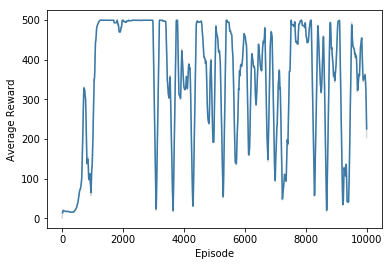

In [12]:
eps, rews = np.array(average_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average Reward')

Text(0, 0.5, 'Total Reward')

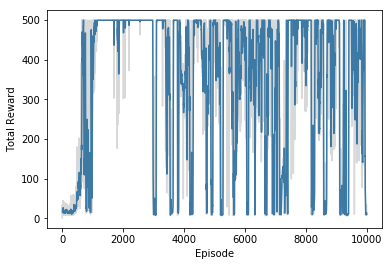

In [13]:
eps, rews = np.array(total_rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

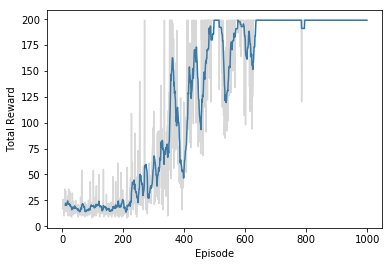

In [181]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [183]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.